# Figures 5, 6 and S12-S15: Assessing the influence of different calibration (and MB model) options on glacier volume projections
- creates these plots for the manuscript and supplements:
    - `fig_5_rel_glac_vol_median_over_rgis_lineplot_model_vs_calib_options_median_gcm_RGI60-11.01450.pdf`
    - `fig_6_rel_vol_to_ref_timodel_calib_option_median_gcm_common_running_ssp126_w_pseudo_daily_fake.pdf`
    - `fig_S12_rel_glac_vol_median_over_rgis_lineplot_model_vs_calib_options_median_gcm_RGI60-11.00897.pdf`
    - `fig_S13_rel_vol_to_ref_timodel_calib_option_median_gcm_common_running_ssp585_w_pseudo_daily_fake.pdf`
    - `fig_S14_temp_clim_comp_median_gcm_common_running_both_ssps_only_pseudo_daily.pdf`
    - `fig_S15_std_volume_ratios_mb_options_for_calib_options_simple_boxplot_median_gcm_common_glaciers_w_fake_pseudo_daily.pdf`

In [1]:
# path where OGGM gdirs are: is created in data_creating_scripts
working_dir = '../oggm_run_gdir_folder/node_folder'
# figure path
fig_path = '../figures'
# data path -> data created from 00_data_creating scripts
data_path = '../01_data'

In [2]:
import xarray as xr
import sys
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import numpy as np
import pandas as pd
col_pal = sns.color_palette(['green','lightgreen','royalblue','lightblue','red', 'orange'])

pd_params_stats = pd.read_csv(f'{data_path}/0_pd_params_stats_not_working_for_all.csv', index_col =0)
warnings.filterwarnings('ignore')


In [3]:
calib_types = ['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']

ds_merged_gcms = xr.open_dataset(f'{data_path}/3_volume_proj_common_running_refs_w5e5_isimip3b.nc')
# just take median over GCMs
ds_merged = ds_merged_gcms.median(dim='gcm')
ensemble = 'median_gcm'

In [4]:
ds_merged_gcms.mb_type

<xarray.DataArray 'mb_type' (mb_type: 4)>
array(['mb_monthly', 'mb_pseudo_daily', 'mb_pseudo_daily_fake',
       'mb_real_daily'], dtype=object)
Coordinates:
  * mb_type  (mb_type) object 'mb_monthly' 'mb_pseudo_daily' ... 'mb_real_daily'

In [5]:
ds_merged_gcms

<xarray.Dataset>
Dimensions:        (time: 101, rgi_id: 85, gcm: 5, melt_f_change: 3,
                    calib_type: 5, ssp: 2, mb_type: 4, grad_type: 2)
Coordinates:
  * time           (time) int64 2000 2001 2002 2003 2004 ... 2097 2098 2099 2100
  * rgi_id         (rgi_id) object 'RGI60-11.02679' ... 'RGI60-02.02631'
  * gcm            (gcm) object 'ukesm1-0-ll_r1i1p1f2' ... 'mri-esm2-0_r1i1p1f1'
  * melt_f_change  (melt_f_change) object 'False' 'neg_exp' 'linear'
  * calib_type     (calib_type) object 'calib_geod_opt_winter_mb_approx_std' ...
  * ssp            (ssp) object 'ssp126' 'ssp585'
  * mb_type        (mb_type) object 'mb_monthly' ... 'mb_real_daily'
  * grad_type      (grad_type) object 'cte' 'var_an_cycle'
Data variables:
    volume         (grad_type, mb_type, ssp, calib_type, melt_f_change, gcm, time, rgi_id) float32 ...
Attributes:
    used climate data:  W5E5 until 2019 + ISIMIP3b (2020-2100)
    created by:         Schuster et al. (2023) with OGGM using the OGGM massb...

### First get some numbers on the glacier volume loss for the text or for the text in the figures

In [6]:
v_2020 = ds_merged_gcms.sel(rgi_id='RGI60-11.00897').sel(time=2020).sel(ssp='ssp126')
v_2020.mean()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     int64 2020
    rgi_id   <U14 'RGI60-11.00897'
    ssp      <U6 'ssp126'
Data variables:
    volume   float32 4.107e+08

**How fast are glaciers with in-situ observations melting?**

for ssp585 -> in 2060 < 4% of 2020 volume left for the 85 ref glaciers:

In [7]:
((ds_merged.sel(ssp='ssp585').sel(time=2060)/ds_merged.sel(ssp='ssp585').sel(time=2020)).median()).volume.values

array(0.04001442)

for ssp126 -> in 2060 ~ 14% of 2020 volume left for the 85 ref glaciers:

In [8]:
((ds_merged.sel(ssp='ssp126').sel(time=2060)/ds_merged.sel(ssp='ssp126').sel(time=2020)).median()).volume.values

array(0.14446847)

In [9]:
(ds_merged.sel(ssp='ssp126').sel(time=2060).median()/ds_merged.sel(ssp='ssp126').sel(time=2020).median()).volume.values

array(0.10611544)

In [10]:
(ds_merged.sel(rgi_id='RGI60-11.00897').sel(time=slice(2047,2100)).volume/ds_merged.sel(rgi_id='RGI60-11.00897').sel(time=2020).volume).max()

<xarray.DataArray 'volume' ()>
array(0.15599933)
Coordinates:
    rgi_id   <U14 'RGI60-11.00897'

**check when the 85 ref glacies lose half of their mass**

In [11]:
v_ref=100*ds_merged_gcms.sel(time=2039).volume/ds_merged_gcms.sel(time=2020)
v_ref =  v_ref.volume.median(dim='gcm') #v_rel.groupby('gcm').median()
#v_ref = v_ref.sel(rgi_id='RGI60-11.00897')
v_ref.median()


<xarray.DataArray 'volume' ()>
array(49.01046753)

more than half of the glaciers melt 50% or more in less than 19 years!!!

In [40]:
v_rel=100*ds_merged_gcms.sel(rgi_id='RGI60-11.01450').sel(time=2099).sel(ssp='ssp126').volume/ds_merged_gcms.sel(rgi_id='RGI60-11.01450').sel(time=2020).sel(ssp='ssp126')
v_rel =  v_rel.volume.median(dim='gcm') #v_rel.groupby('gcm').median()
v_rel_c5 = v_rel.sel(calib_type=calib_types[-1])
print(f'maximum difference in volume estimates of Aletschglacier from all different TI-model'+
      f'options in 2099 for ssp126:  {(v_rel_c5.max()-v_rel_c5.min()).values:.0f}% of 2020 volume')

v_rel_refTI = v_rel.sel(grad_type='cte').sel(melt_f_change='False').sel(mb_type='mb_monthly')
print(f'maximum difference in volume estimates of Aletschglacier from all different calib'+
      f'options using ref TI-model option in 2099 for ssp126:  {(v_rel_refTI.max()-v_rel_refTI.min()).values:.1f}% of 2020 volume')

maximum difference in volume estimates of Aletschglacier from all different TI-modeloptions in 2099 for ssp126:  24% of 2020 volume
maximum difference in volume estimates of Aletschglacier from all different caliboptions using ref TI-model option in 2099 for ssp126:  27.0% of 2020 volume


In [13]:
v_rel_refTI.values

array([17.479412, 17.479412, 17.766626, 44.37533 , 39.52769 ],
      dtype=float32)

**for how many options does Aletsch glacier disappear almost completely (<0.5%) with ssp585 until 2100???**

In [14]:
ds_merged_gcms_sel = ds_merged_gcms.sel(mb_type = ['mb_monthly', 'mb_pseudo_daily_fake',
       'mb_real_daily'])
v_rel_ssp585=100*ds_merged_gcms_sel.sel(rgi_id='RGI60-11.01450').sel(time=2100).sel(ssp='ssp585').volume/ds_merged_gcms_sel.sel(rgi_id='RGI60-11.01450').sel(time=2020).sel(ssp='ssp585')
v_rel_ssp585 = v_rel_ssp585.volume.median(dim='gcm') #v_rel.groupby('gcm').median()
v_rel_ssp585 = v_rel_ssp585.sel(calib_type=calib_types[-1])


In [15]:
pd_rel_ssp585_vanish = (v_rel_ssp585 <0.5).to_dataframe()[['volume']]
pd_rel_ssp585_vanish.loc[pd_rel_ssp585_vanish.volume==True].count()

volume    9
dtype: int64

-> for 9 out of 18 options, Aletsch glacier disappears almost completely in ssp585 until 2100

In [16]:
v_rel=100*ds_merged_gcms_sel.sel(rgi_id='RGI60-11.01450').sel(time=2100).sel(ssp='ssp126').volume/ds_merged_gcms_sel.sel(rgi_id='RGI60-11.01450').sel(time=2020).sel(ssp='ssp126')
v_rel =  v_rel.volume.median(dim='gcm') #v_rel.groupby('gcm').median()
print(f'maximum difference in volume estimates of Aletschglacier from all different options in 2100 for ssp126:  {(v_rel.max()-v_rel.min()).values:.1f}% of 2020 volume')

maximum difference in volume estimates of Aletschglacier from all different options in 2100 for ssp126:  40.1% of 2020 volume


### Fig. 5 & Fig. S12 - Volume change plots for single glaciers: influence of TI-model option vs calib-option

RGI60-11.01450
mb_model_influence ssp126: year with largest IQR 2096.0
mb_model_influence ssp126: maximum IQR: 8.63133716583252
mb_model_influence ssp585: year with largest IQR 2064.0
mb_model_influence ssp585: maximum IQR: 6.766706466674805
mean volume in 2020: 11.733646336km3, max-min: 0.091815936km3
std in 2020: 0.028161548km3
calib_influence ssp126: year with largest IQR 2096.0
calib_influence ssp126: maximum IQR: 23.080707550048828
calib_influence ssp585: year with largest IQR 2045.0
calib_influence ssp585: maximum IQR: 18.778247833251953
mean volume in 2020: 11.827226624km3, max-min: 0.157749248km3
std in 2020: 0.067690512km3


RGI60-11.00897
mb_model_influence ssp126: year with largest IQR 2033.0
mb_model_influence ssp126: maximum IQR: 5.730372428894043
mb_model_influence ssp585: year with largest IQR 2033.0
mb_model_influence ssp585: maximum IQR: 6.769438743591309
mean volume in 2020: 0.41029232km3, max-min: 0.008697344km3
std in 2020: 0.00285409675km3
calib_influence ssp126: y

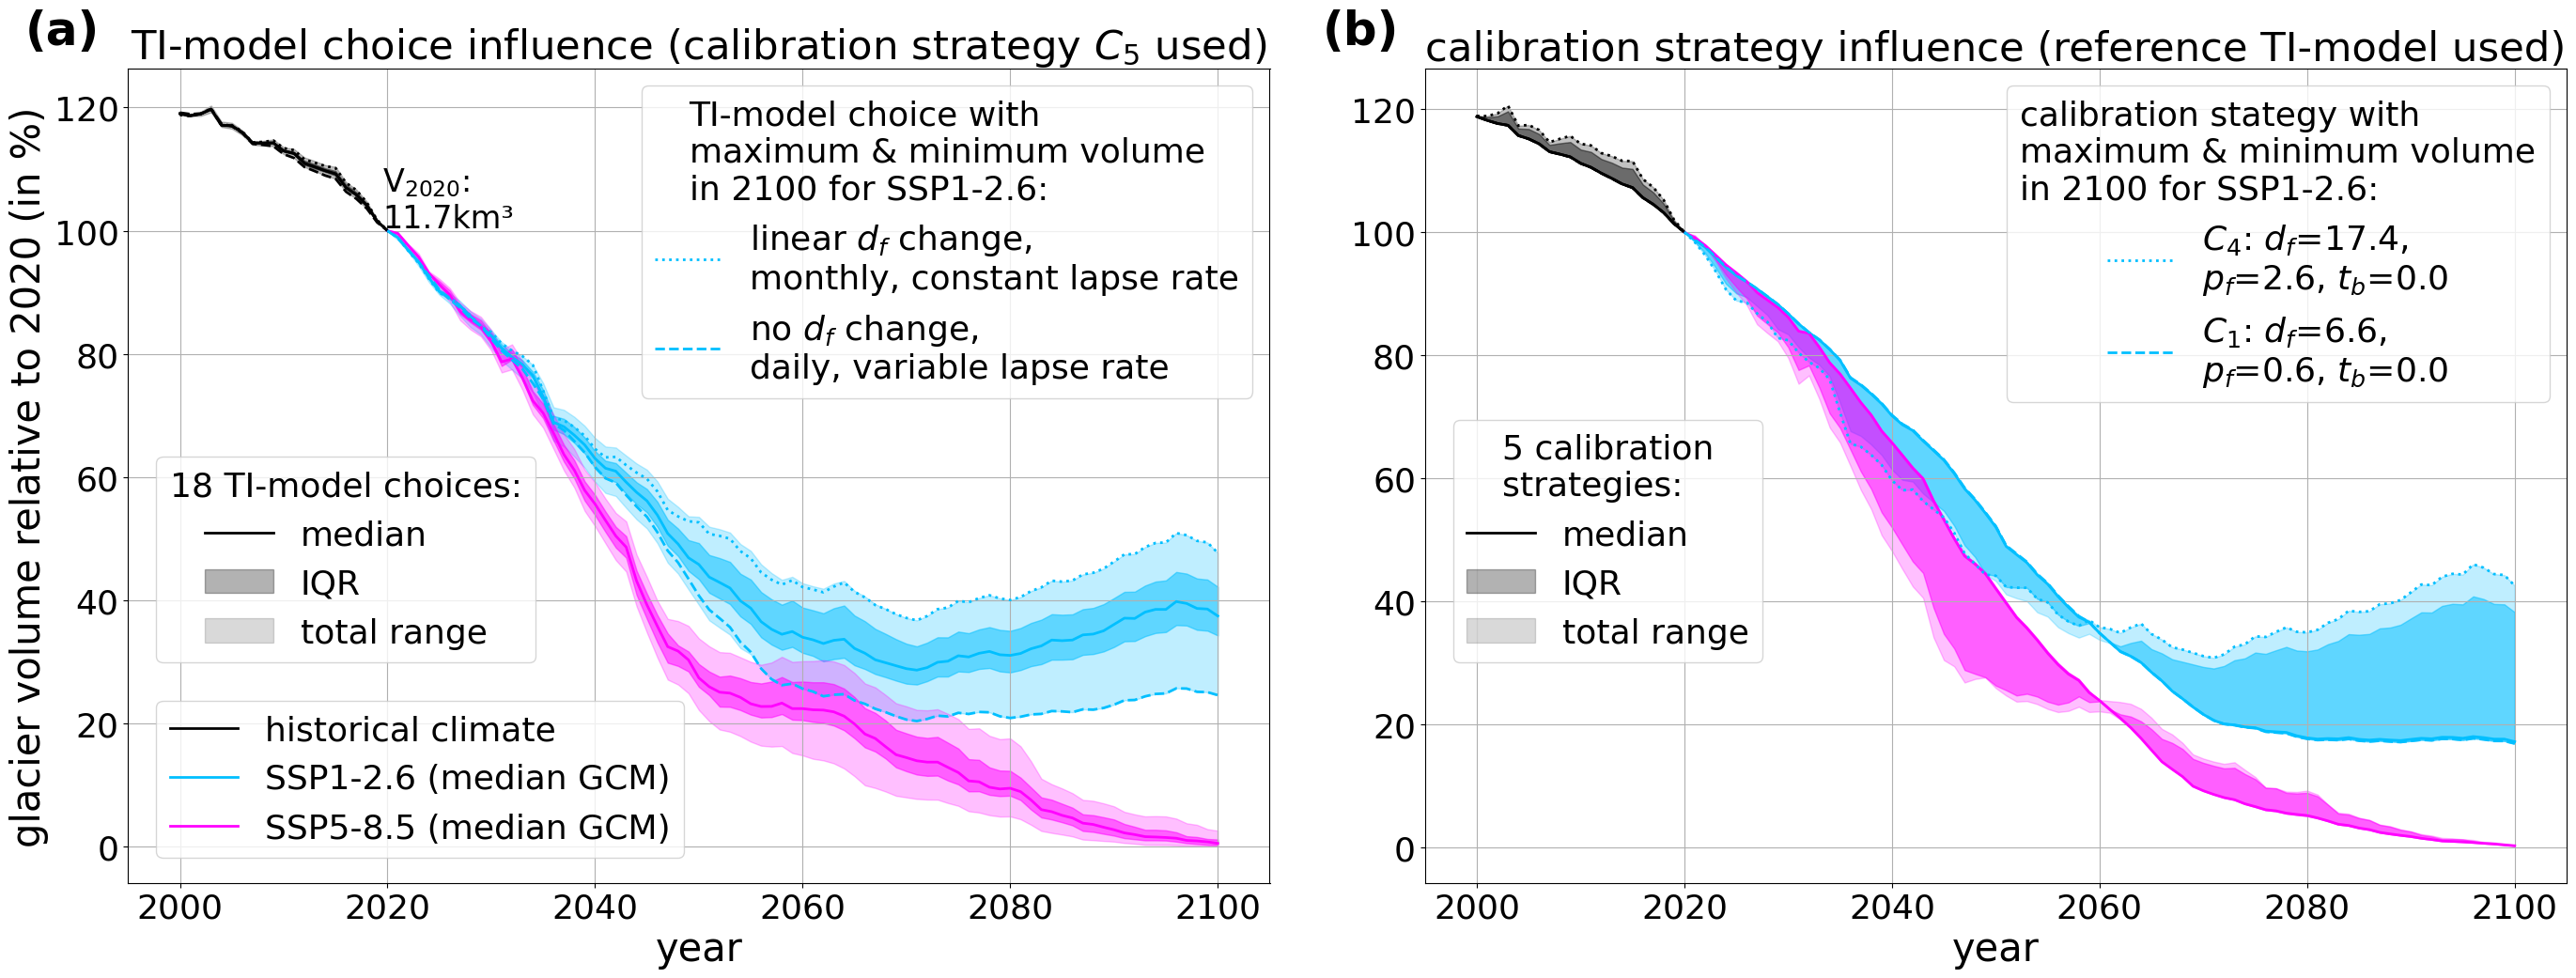

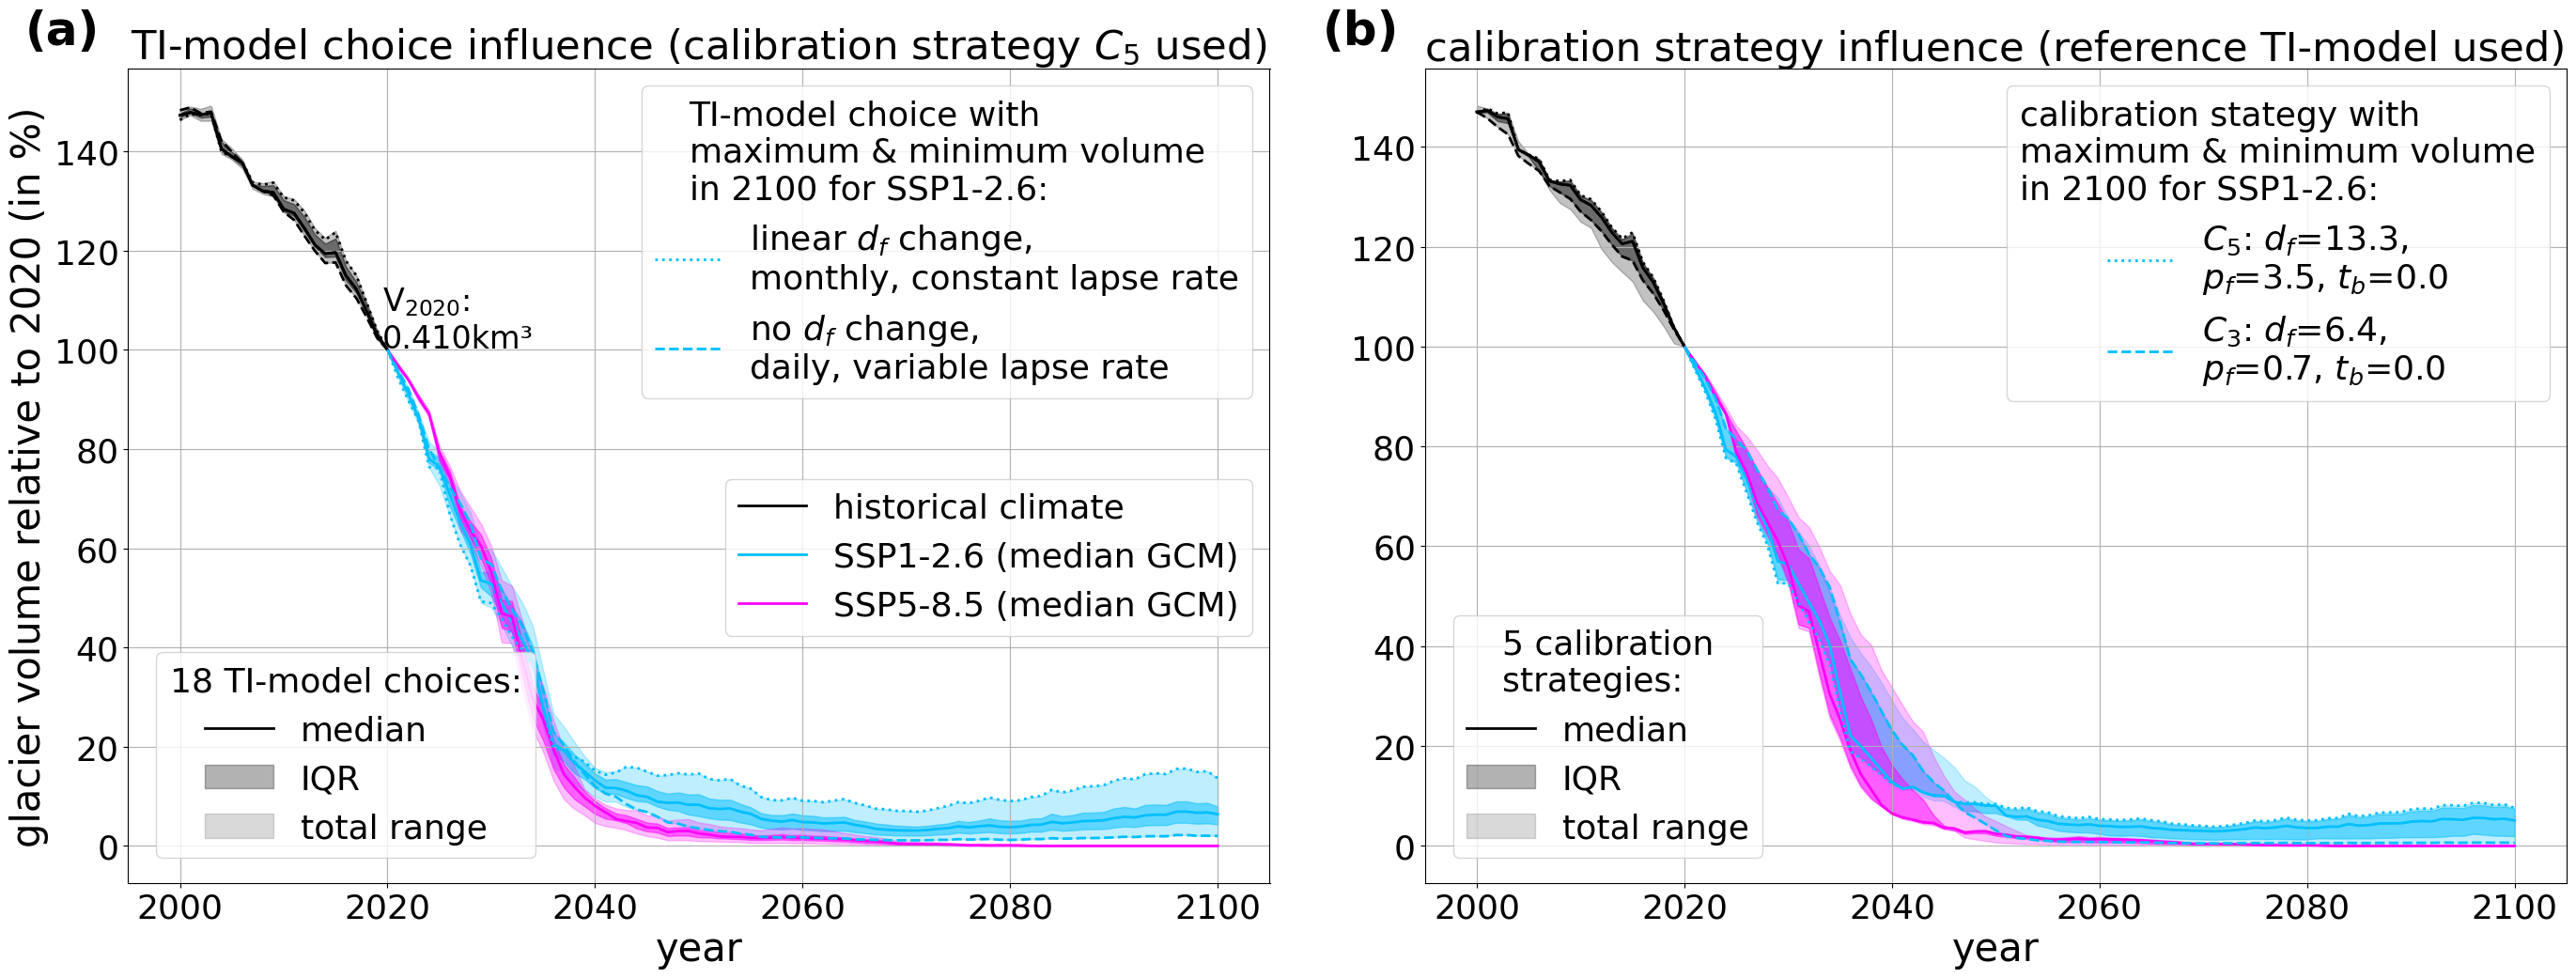

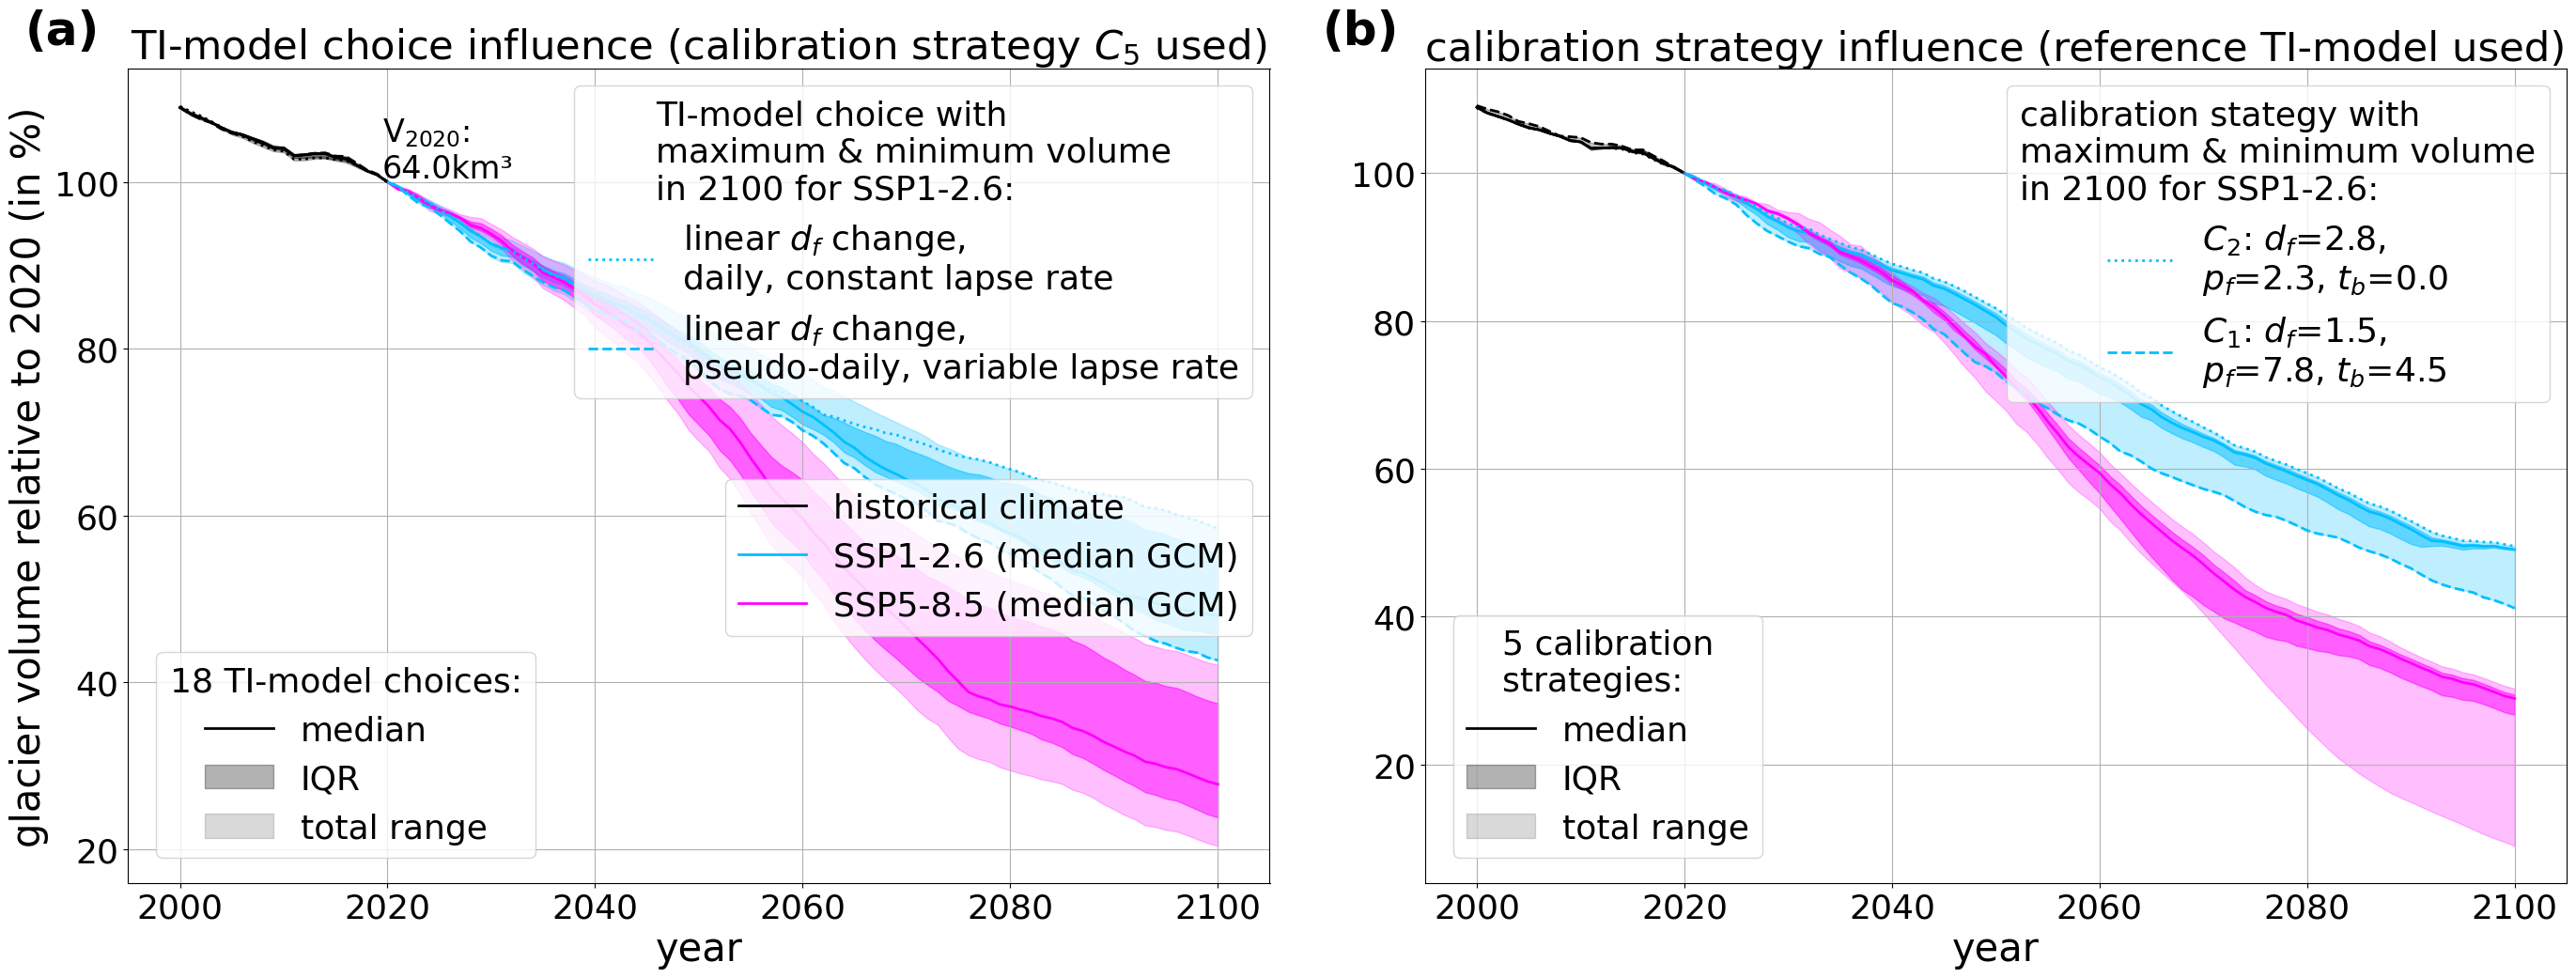

In [34]:
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)',
            6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 

fac_per_month_to_per_day = 365.25/12

num_text_x = -0.09
num_text_y = 1.03
ensemble = 'median_gcm'
plt.rc('font', size=26)
manuscript=True
for rgi in ['RGI60-11.01450', 'RGI60-11.00897', 'RGI60-06.00234']: #,'RGI60-11.01450', 'RGI60-06.00234']:
    print(rgi)
    if not manuscript:
        plt.suptitle(rgi)
    
    fig, axss = plt.subplots(1,2, figsize=(28,11))
    for j,plot_option in enumerate(['mb_model_influence', 'calib_influence']):
        axs = [axss[j]]
        
        if plot_option == 'calib_influence':
            if manuscript:
                axs[0].text(num_text_x,num_text_y, num_dict[j],weight='bold',
                    fontsize=36, transform=axs[0].transAxes)
                axs[0].set_title('calibration strategy influence (reference TI-model used)') #':\nno melt_f change, monthly, constant lapse rate)')
            else:
                axs[0].set_title('calibration strategy influence (reference TI-model of OGGM applied:\nno'+r' $d_f$'+' change, monthly, constant lapse rate)')
            # for the moment just select one MB options for simplification
            # ds_merged_gcms = xr.open_dataset('all_refs_W5E5_all_gcms.nc')
            ds_merged = ds_merged_gcms.median(dim='gcm')
            ds_merged = ds_merged.sel(mb_type='mb_monthly', grad_type = 'cte',
                                      melt_f_change='False')

        elif plot_option == 'mb_model_influence':
            if manuscript:
                axs[0].text(num_text_x,num_text_y, num_dict[j],weight='bold',
                    fontsize=36, transform=axs[0].transAxes)
                axs[0].set_title(r'TI-model choice influence (calibration strategy $C_5$ used)') #':\ngeodetic matched, prcp. fac dependent on winter precitation)')
            else:
                axs[0].set_title('TI-model influence (option (E) for calibration used:\ngeodetic matched, prcp. fac dependent on winter prcp.)')

            # instead just take the MEDIAN!!!
            ds_merged = ds_merged_gcms.median(dim='gcm')
            ds_merged = ds_merged.sel(mb_type = ['mb_monthly', 'mb_pseudo_daily_fake','mb_real_daily'])
            ds_merged = ds_merged.sel(calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb')

        ds_merged_2020 = ds_merged.sel(time=2020)
        df_merged_vol_yr = ds_merged.sel(time=slice(2000,2101)).to_dataframe().reset_index()
        # rename it again 'mb_pseudo_daily'
        df_merged_vol_yr.loc[df_merged_vol_yr.mb_type == 'mb_pseudo_daily_fake', 'mb_type'] = 'mb_pseudo_daily'
        df_merged_vol_yr['mb_grad_type'] = df_merged_vol_yr['mb_type'] + '_' + df_merged_vol_yr['grad_type']
        df_merged_vol_yr['sfc_type'] = df_merged_vol_yr['melt_f_change']
        df_merged_vol_yr.loc[df_merged_vol_yr.melt_f_change!='False', 'sfc_type'] +='\nmonthly'
        fs = []
        for f in df_merged_vol_yr['mb_grad_type']:
            fs.append(f[3:])
        df_merged_vol_yr['mb_grad_type'] = fs
        df_vol_sum_yr = df_merged_vol_yr.groupby(['calib_type', 'mb_grad_type',
                                                  'sfc_type', 'ssp', 'time']).sum().copy().reset_index()
        df_merged_vol_yr['relative individual glacier volume compared to 2020 (%)'] = (100*ds_merged.sel(time=slice(2000,2101))/ds_merged_2020).to_dataframe().reset_index().volume

        # df_merged_vol_yr_median = df_merged_vol_yr.groupby(['mb_grad_type', 'ssp', 'calib_type', 'time']).median().reset_index()
        pd_params_stats_sel = pd_params_stats.loc[(pd_params_stats.mb_grad_type == 'mb_monthly_cte') & (pd_params_stats.sfc_type =='False')].loc[rgi]
        df_merged_vol_yr_median_a= df_merged_vol_yr.loc[df_merged_vol_yr.rgi_id==rgi].groupby(['mb_grad_type', 'ssp', 'calib_type',
                                                                                               'time', 'sfc_type']).median().reset_index()

        d_hef = df_merged_vol_yr.loc[(df_merged_vol_yr.rgi_id==rgi) & (df_merged_vol_yr.time == 2100)].groupby(['mb_grad_type', 'ssp',
                                                                                                                'calib_type', 'time',
                                                                                                                'melt_f_change']).median()[['relative individual glacier volume compared to 2020 (%)']]
        d_hef = d_hef.query("ssp=='ssp126'").sort_values(by='relative individual glacier volume compared to 2020 (%)')
        mb_grad_type_min, _, calib_min,_, sfc_type_min = d_hef.iloc[0].name
        mb_grad_type_max, _, calib_max,_, sfc_type_max = d_hef.iloc[-1].name
        #mb_grad_type_min = mb_grad_type_min[3:]
        #mb_grad_type_max = mb_grad_type_max[3:]

        # median over rgi_ids
        #fig, axs = plt.subplots(1,2, figsize=(14,11))
        #axs = [axs]
        for ssp in ds_merged.ssp.values:
            for period in ['hist', 'future']:
                if period == 'hist':
                    df_merged_vol_yr_median = df_merged_vol_yr_median_a.where(df_merged_vol_yr_median_a.time<=2020).dropna()
                    color_ssp_d = {'ssp126':'black', 'ssp585':'black'}
                    a = -0.1
                    if ssp == 'ssp585':
                        a = -0.15

                elif period == 'future':
                    a=0
                    df_merged_vol_yr_median = df_merged_vol_yr_median_a.where(df_merged_vol_yr_median_a.time>=2020).dropna()
                    #color_ssp_d = {'ssp126':'blue', 'ssp585':'red'}
                    color_ssp_d = {'ssp126':sns.color_palette(['deepskyblue'])[0], 'ssp585':'magenta'}

                d_merged_stats = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').median().reset_index()
                d_q975 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').max().reset_index()['relative individual glacier volume compared to 2020 (%)']
                d_q025 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').min().reset_index()['relative individual glacier volume compared to 2020 (%)']

                d_q75 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').quantile([0.75]).reset_index()['relative individual glacier volume compared to 2020 (%)']
                d_q25 = df_merged_vol_yr_median.loc[df_merged_vol_yr_median.ssp==ssp].groupby('time').quantile([0.25]).reset_index()['relative individual glacier volume compared to 2020 (%)']
                d_merged_stats['median glacier volume relative to 2020'] = d_merged_stats['relative individual glacier volume compared to 2020 (%)'].values
                d_merged_stats['interquartile range of \nglacier volume relative to 2020'] = d_q75-d_q25
                axs[0].plot(d_merged_stats.time, d_merged_stats['median glacier volume relative to 2020'], label=f'median', color=color_ssp_d[ssp], linewidth=2)

                axs[0].fill_between(d_merged_stats.time, d_q75, d_q25,
                                    alpha = 0.5+2*a, label=f'IQR', color=color_ssp_d[ssp])    
                axs[0].fill_between(d_merged_stats.time, d_q975, d_q025,
                                    alpha = 0.25+a, label=f'total range', color=color_ssp_d[ssp])    
                if period == 'future':
                    print(f'{plot_option} {ssp}: year with largest IQR {d_merged_stats.loc[(d_q75-d_q25).argmax()].time}')
                    print(f'{plot_option} {ssp}: maximum IQR: {(d_q75-d_q25).max()}')

        handles, labels = axs[0].get_legend_handles_labels()
        if rgi == 'RGI60-11.01450':
            loc1 = 'lower left'
            loc2 = 'lower left'
            bbox_to_anchor_1 = (0.01,0.25)
            bbox_to_anchor_2 = (0.01,0.01)

        else:
            loc1 = 'lower left'
            loc2 = 'center right'
            bbox_to_anchor_1 = (0.01,0.01)
            bbox_to_anchor_2 = (1,0.4)

        if plot_option == 'calib_influence':
            order = [0,1,2]
            leg1=axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], #bbox_to_anchor =(0.41,0.725),
                               loc = loc1, bbox_to_anchor =bbox_to_anchor_1,
                               title='5 calibration\nstrategies:')
            order = [0,3,9]
            leg2=axs[0].legend([handles[idx] for idx in order],['historical climate',
                                                                f'SSP1-2.6 (median GCM)',
                                                                f'SSP5-8.5 (median GCM)'],
                               #bbox_to_anchor =(1,0.725),
                               loc = loc2, bbox_to_anchor=bbox_to_anchor_2) #right
        elif plot_option == 'mb_model_influence': 
            order = [0,1,2] #8,9]
            leg1=axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], #bbox_to_anchor =(0.41,0.725), loc = 'lower left',
                               loc = loc1, bbox_to_anchor =bbox_to_anchor_1,
                               title='18 TI-model choices:')
            order = [0,3,9] #1,3]
            leg2=axs[0].legend([handles[idx] for idx in order],['historical climate',
                                                                f'SSP1-2.6 (median GCM)',
                                                                f'SSP5-8.5 (median GCM)'],
                               #bbox_to_anchor =(1,0.725),
                               loc = loc2, bbox_to_anchor=bbox_to_anchor_2) #right

        d_hef_timeline_a = df_merged_vol_yr.loc[df_merged_vol_yr.rgi_id==rgi].groupby(['mb_grad_type', 'ssp', 'calib_type',
                                                                                       'time',
                                                                                       'melt_f_change']).median().to_xarray()

        for period in ['hist', 'future']:
            if period == 'hist':
                d_hef_timeline = d_hef_timeline_a.where(d_hef_timeline_a.time<=2020).dropna(dim='time')
                color_sel = 'black'
            elif period == 'future':
                d_hef_timeline = d_hef_timeline_a.where(d_hef_timeline_a.time>=2020).dropna(dim='time')
                color_sel = sns.color_palette(['deepskyblue'])[0] 
            d_hef_timeline_max = d_hef_timeline.sel(ssp='ssp126').sel(calib_type=calib_max).sel(mb_grad_type = mb_grad_type_max).sel(melt_f_change=sfc_type_max) #(dim='mb_grad_type') #, 'calib_type', 'sfc_type'])
            if sfc_type_max == 'False':
                sfc_type_max_poster = r'no $d_f$ change, '
            elif sfc_type_max == 'linear':
                sfc_type_max_poster = r'linear $d_f$ change, '
            else:
                sys.exit('need more options sfc_type_max_poster')
            if mb_grad_type_max == 'mb_monthly_cte' or mb_grad_type_max == 'monthly_cte':
                mb_grad_type_max_poster = '\nmonthly, constant lapse rate'
            elif mb_grad_type_max == 'real_daily_var_an_cycle':
                mb_grad_type_max_poster = '\ndaily, variable lapse rate'
            elif mb_grad_type_max == 'monthly_var_an_cycle':
                mb_grad_type_max_poster = '\nmonthly, variable lapse rate'
            elif mb_grad_type_max == 'real_daily_cte':
                mb_grad_type_max_poster = '\ndaily, constant lapse rate'
            else:
                sys.exit('need more options mb_grad_type_max_poster')
            if calib_max == 'calib_geod_opt_winter_mb_approx_std':
                calib_max_poster = '(a) geodetic, winter MB & ~ interannual variability matched'
                if manuscript:
                    calib_max_poster = r'$C_1$'
            elif calib_max == 'calib_geod_opt_winter_mb_temp_b_0':
                calib_max_poster = '(b) geodetic & winter MB matched'
                if manuscript:
                    calib_max_poster = r'$C_2$'
            elif calib_max == 'calib_geod_opt_std_temp_b_0':
                calib_max_poster = '(c) geodetic & interannual variability matched'
                if manuscript:
                    calib_max_poster = r'$C_3$'
            elif calib_max == 'calib_only_geod_temp_b_0_pf_cte_via_std':
                calib_max_poster = r'(d) geodetic matched, $p_f$ from median of option (c)'
                if manuscript:
                    calib_max_poster = r'$C_4$'
            elif calib_max == 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb':
                calib_max_poster = r'(e) geodetic matched, $p_f$ dependent on winter prcp.'
                if manuscript:
                    calib_max_poster = r'$C_5$'
            if plot_option == 'calib_influence':
                pd_params_stats_sel_calib = pd_params_stats_sel.loc[pd_params_stats_sel.calib_type == calib_max]
                melt_f = pd_params_stats_sel_calib['melt_f'].values[0]/fac_per_month_to_per_day
                prcp_fac = pd_params_stats_sel_calib['pf_opt'].values[0]
                temp_b = pd_params_stats_sel_calib['temp_bias'].values[0]
                label_max = (f'{calib_max_poster}: '+
                             r'$d_f$'+f'={melt_f:.1f},\n'+
                             r'$p_f$'+f'={prcp_fac:.1f}, '+r'$t_b$'+f'={temp_b:.1f}')
            elif plot_option == 'mb_model_influence':
                label_max = f'{sfc_type_max_poster}{mb_grad_type_max_poster}'
            axs[0].plot(d_hef_timeline_max.time,
                        d_hef_timeline_max['relative individual glacier volume compared to 2020 (%)'],
                        color = color_sel, ls = ':', alpha = 1, lw=2,label=label_max)
            d_hef_timeline_min = d_hef_timeline.sel(ssp='ssp126').sel(calib_type=calib_min).sel(mb_grad_type = mb_grad_type_min).sel(melt_f_change=sfc_type_min) #(dim='mb_grad_type') #, 'calib_type', 'sfc_type'])
            if sfc_type_min == 'False':
                sfc_type_min_poster = r'no $d_f$ change, '
            elif sfc_type_min == 'linear':
                sfc_type_min_poster = r'linear $d_f$ change, '
            else:
                sys.exit('need more options sfc_type_min_poster')
            if mb_grad_type_min == 'monthly_cte':
                mb_grad_type_min_poster = '\nmonthly, constant lapse rate'
            elif mb_grad_type_min == 'real_daily_var_an_cycle':
                mb_grad_type_min_poster = '\ndaily, variable lapse rate'
            elif mb_grad_type_min == 'monthly_var_an_cycle':
                mb_grad_type_min_poster = '\nmonthly, variable lapse rate'
            elif mb_grad_type_min == 'pseudo_daily_cte':
                mb_grad_type_min_poster = '\npseudo-daily, constant lapse rate'
            elif mb_grad_type_min == 'pseudo_daily_var_an_cycle':
                mb_grad_type_min_poster = '\npseudo-daily, variable lapse rate'
            elif mb_grad_type_min == 'real_daily_cte':
                mb_grad_type_min_poster = '\ndaily, constant lapse rate'
            elif mb_grad_type_min == 'real_daily_var_an_cycle':
                mb_grad_type_min_poster = '\ndaily, variable lapse rate'
            else:
                sys.exit('need more options mb_grad_type_min_poster')

            if calib_min == 'calib_geod_opt_winter_mb_approx_std':
                calib_min_poster = '(a) geodetic, winter MB & ~ interannual variability matched'
                if manuscript:
                    calib_min_poster = r'$C_1$'
            elif calib_min == 'calib_geod_opt_winter_mb_temp_b_0':
                calib_min_poster = '(b) geodetic & winter MB matched'
                if manuscript:
                    calib_min_poster = r'$C_2$'
            elif calib_min == 'calib_geod_opt_std_temp_b_0':
                calib_min_poster = '(c) geodetic & interannual variability matched'
                if manuscript:
                    calib_min_poster = r'$C_3$'
            elif calib_min == 'calib_only_geod_temp_b_0_pf_cte_via_std':
                calib_min_poster = '(d) geodetic matched, prcp. fac from median of option (c)'
                if manuscript:
                    calib_min_poster = r'$C_4$'
            elif calib_min == 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb':
                calib_min_poster = '(e) geodetic matched, prcp. fac dependent on winter prcp.'
                if manuscript:
                    calib_min_poster = r'$C_5$'
            if plot_option == 'calib_influence':
                pd_params_stats_sel_calib = pd_params_stats_sel.loc[pd_params_stats_sel.calib_type == calib_min]
                melt_f = pd_params_stats_sel_calib['melt_f'].values[0]/fac_per_month_to_per_day
                prcp_fac = pd_params_stats_sel_calib['pf_opt'].values[0]
                temp_b = pd_params_stats_sel_calib['temp_bias'].values[0]
                label_min = (f'{calib_min_poster}: '+
                             r'$d_f$'+f'={melt_f:.1f},\n'+
                             r'$p_f$'+f'={prcp_fac:.1f}, '+r'$t_b$'+f'={temp_b:.1f}')
            elif plot_option == 'mb_model_influence':
                label_min = f'{sfc_type_min_poster}{mb_grad_type_min_poster}'
            axs[0].plot(d_hef_timeline_min.time,
                        d_hef_timeline_min['relative individual glacier volume compared to 2020 (%)'],
                        color = color_sel, ls = '--', alpha = 1, lw=2,
                        label=label_min)


        handles, labels = axs[0].get_legend_handles_labels()
        if plot_option == 'calib_influence':
            legend_title = 'calibration stategy with\nmaximum & minimum volume\nin 2100 for SSP1-2.6:'
        elif plot_option == 'mb_model_influence':
            legend_title = 'TI-model choice with\nmaximum & minimum volume\nin 2100 for SSP1-2.6:'

        leg3 = axs[0].legend(handles[-2:], labels[-2:], #[6:8], #handles[-2:], labels[-2:],
                                 loc = 'upper right',
                             #bbox_to_anchor =(0.0,0),
                             title = legend_title)

        axs[0].add_artist(leg1)
        if plot_option == 'mb_model_influence':
            axs[0].add_artist(leg2)

        axs[0].grid()# overall MB and calib option influence

        axs[0].set_xlabel('year', fontsize=30)

        mean_vol = d_hef_timeline_a.sel(time=2020).volume.mean().values/1e9
        print(f'mean volume in 2020: {mean_vol}km3, max-min: {(d_hef_timeline_a.sel(time=2020).volume.max().values-d_hef_timeline_a.sel(time=2020).volume.min().values)/1e9}km3')
        std = d_hef_timeline_a.sel(time=2020).volume.std().values/1e9
        print(f'std in 2020: {std}km3')
        if mean_vol <1:
            if plot_option == 'mb_model_influence':
                axs[0].text(2019.5,100.5,
                            r'V$_{2020}$:'+f'\n{mean_vol:.3f}km³',# +r'$\pm$' + f'{std:.3f}km³',
                            fontsize=24) #, transform=axs[0].transAxes)
        else:
            if plot_option == 'mb_model_influence':
                axs[0].text(2019.5,100.5,
                            r'V$_{2020}$:'+f'\n{mean_vol:.1f}km³', # +r'$\pm$' + f'{std:.1f}km³',
                            fontsize=24) #, transform=axs[0].transAxes)
        if not manuscript:
            if rgi == 'RGI60-11.01450':
                axs[0].text(2067,120.05, 'Aletsch glacier (Swiss Alps)',
                            fontsize=22) #, transform=axs[0].transAxes)
        if plot_option != 'calib_influence':
            axs[0].set_ylabel('glacier volume relative to 2020 (in %)', fontsize=30)
        else:
            axs[0].set_ylabel('glacier volume relative to 2020 (in %)', fontsize=30, alpha = 0)
        plt.tight_layout()

    
    if manuscript:
        if rgi == 'RGI60-11.01450':
            plt.savefig(f'{fig_path}/fig_5_rel_glac_vol_median_over_rgis_lineplot_model_vs_calib_options_{ensemble}_{rgi}.pdf')
        elif rgi =='RGI60-11.00897':
            plt.savefig(f'{fig_path}/figures_supplements/fig_S12_rel_glac_vol_median_over_rgis_lineplot_model_vs_calib_options_{ensemble}_{rgi}.pdf')
        else:
            pass
    print('\n')

### Fig. 6: Volume projection plot: comparison of TI-model and calib option influence for all ref. glacier 

In [18]:
#assert xr.__version__ == '0.21.1'
# if not, the figure construction below works only with that xarray version
# do pip install xarray==0.21.1 # 0.8.0

In [21]:
calib_type_to_compare = 'calib_geod_opt_winter_mb_approx_std'  # reference calib option for the last subplot -> equal to C1

In [22]:
# we do not want the "REAL" mb_pseudo_daily, but just the fake one
# which hast interannually constant daily temperature standard deviations
ds_merged = ds_merged_gcms_sel.median(dim='gcm')

In [23]:
ds_merged.mb_type

<xarray.DataArray 'mb_type' (mb_type: 3)>
array(['mb_monthly', 'mb_pseudo_daily_fake', 'mb_real_daily'], dtype=object)
Coordinates:
  * mb_type  (mb_type) object 'mb_monthly' ... 'mb_real_daily'

In [24]:
ensemble = 'median_gcm'
plt.rc('font', size=20)
col_pal_ssp = sns.color_palette(['deepskyblue', 'red'])

ds_m = ds_merged.sel(time=slice(2040,2100,60)).copy() #.to_dataframe().reset_index() 
len_rgis_run = len(ds_m.rgi_id)
pd_len_rgis = pd.DataFrame(columns=['ssp', 'time', 'still_exist', 'all'])
j = 0
working_dict = {}
for time in [2040, 2100]: #099
    for ssp in ['ssp126', 'ssp585']:
        # any: it is sufficient that there is for one MB model type or calib type a 0 value -> then it is dropped
        working_dict[f'{time}_{ssp}'] = ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=time).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id.values
        len_rgis_run_t = len(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=time).volume>1).dropna(dim='rgi_id', how='any').rgi_id)
        pd_len_rgis.loc[j] = np.array([ssp, time, len_rgis_run_t, len_rgis_run])
        j += 1
pd_len_rgis['still_exist'] = pd_len_rgis['still_exist'].astype(int)

calib_types_nice = ['(A) geodetic, avg. winter MB & std. \nof interannual variability matched',
                    '(B) geodetic & avg. winter MB\nmatched',
                    '(C) geodetic & std. of interannual\nvariability matched',
                    '(D) geodetic matched, prcp. fac\nfrom median of option (C)',
                    '(E) geodetic matched, prcp. fac\ndependent on winter prcp.']


ref_vol_option = ds_merged.volume.sel(calib_type=calib_type_to_compare)
ds_merged_vs_ref_each_calib_option = ds_merged.volume/ref_vol_option 
ds_merged_vs_ref_each_calib_option = ds_merged_vs_ref_each_calib_option.where(ds_merged_vs_ref_each_calib_option < np.inf, drop=True) #, ds_merged_vs_ref_each_option.values)
ds_merged_vs_ref_each_calib_option = ds_merged_vs_ref_each_calib_option.where(ds_merged_vs_ref_each_calib_option >0, drop=True) #, ds_merged_vs_ref_each_option.values)


In [25]:
ds_merged_vs_ref_each_calib_option.calib_type

<xarray.DataArray 'calib_type' (calib_type: 5)>
array(['calib_geod_opt_winter_mb_approx_std',
       'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
       'calib_only_geod_temp_b_0_pf_cte_via_std',
       'calib_only_geod_temp_b_0_pf_fit_via_winter_mb'], dtype=object)
Coordinates:
  * calib_type  (calib_type) object 'calib_geod_opt_winter_mb_approx_std' ......

In [26]:
pd_len_rgis

,ssp,time,still_exist,all
0,ssp126,2040,69,85
1,ssp585,2040,68,85
2,ssp126,2100,45,85
3,ssp585,2100,15,85


var_an_cycle temperature lapse rate choice 0.25    0.616385
0.50    0.810614
0.75    0.961048
Name: volume, dtype: float64
mb_pseudo_daily_fake temporal climate resolution choice 0.25    0.966733
0.50    1.004272
0.75    1.077125
Name: volume, dtype: float64
mb_real_daily temporal climate resolution choice 0.25    0.830946
0.50    0.974123
0.75    1.171210
Name: volume, dtype: float64
neg_exp $d_f$ change choice for different surface types 0.25    0.968181
0.50    1.036997
0.75    1.221426
Name: volume, dtype: float64
linear $d_f$ change choice for different surface types 0.25    0.912493
0.50    1.054632
0.75    1.415509
Name: volume, dtype: float64
var_an_cycle temperature lapse rate choice 0.25    0.732950
0.50    0.893298
0.75    0.990459
Name: volume, dtype: float64
mb_pseudo_daily_fake temporal climate resolution choice 0.25    0.933275
0.50    1.008501
0.75    1.152744
Name: volume, dtype: float64
mb_real_daily temporal climate resolution choice 0.25    0.692059
0.50    0.934168

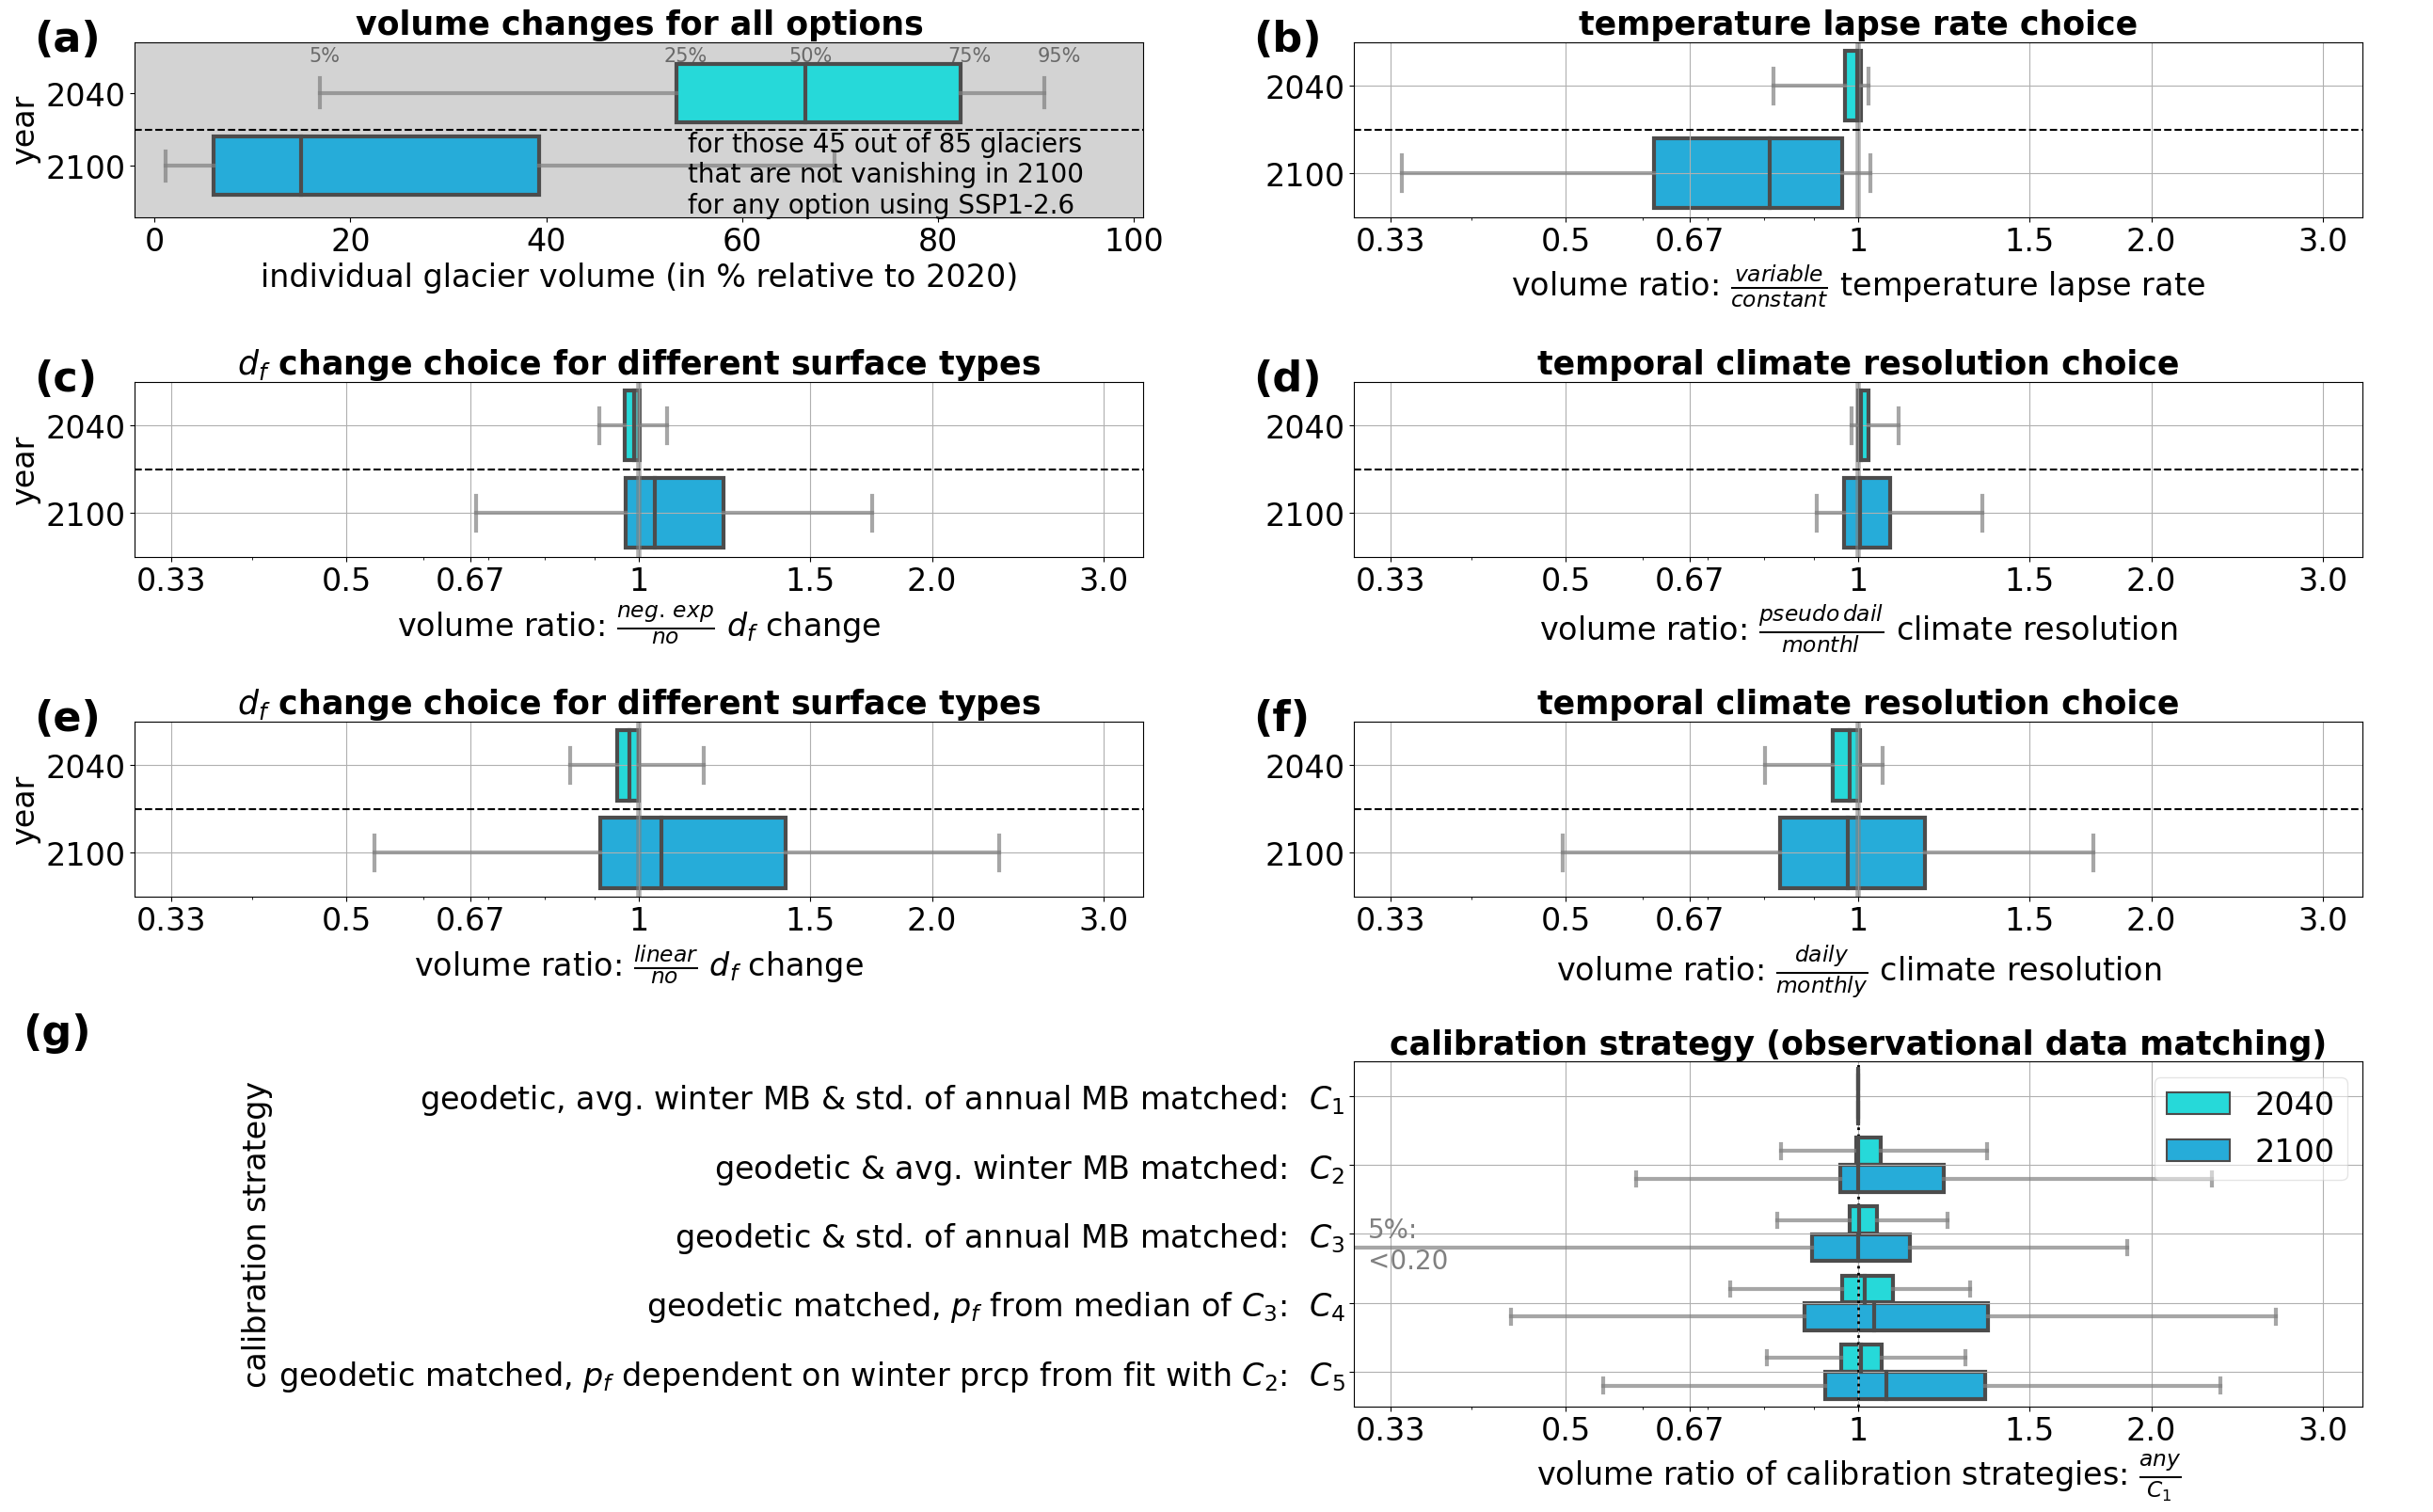

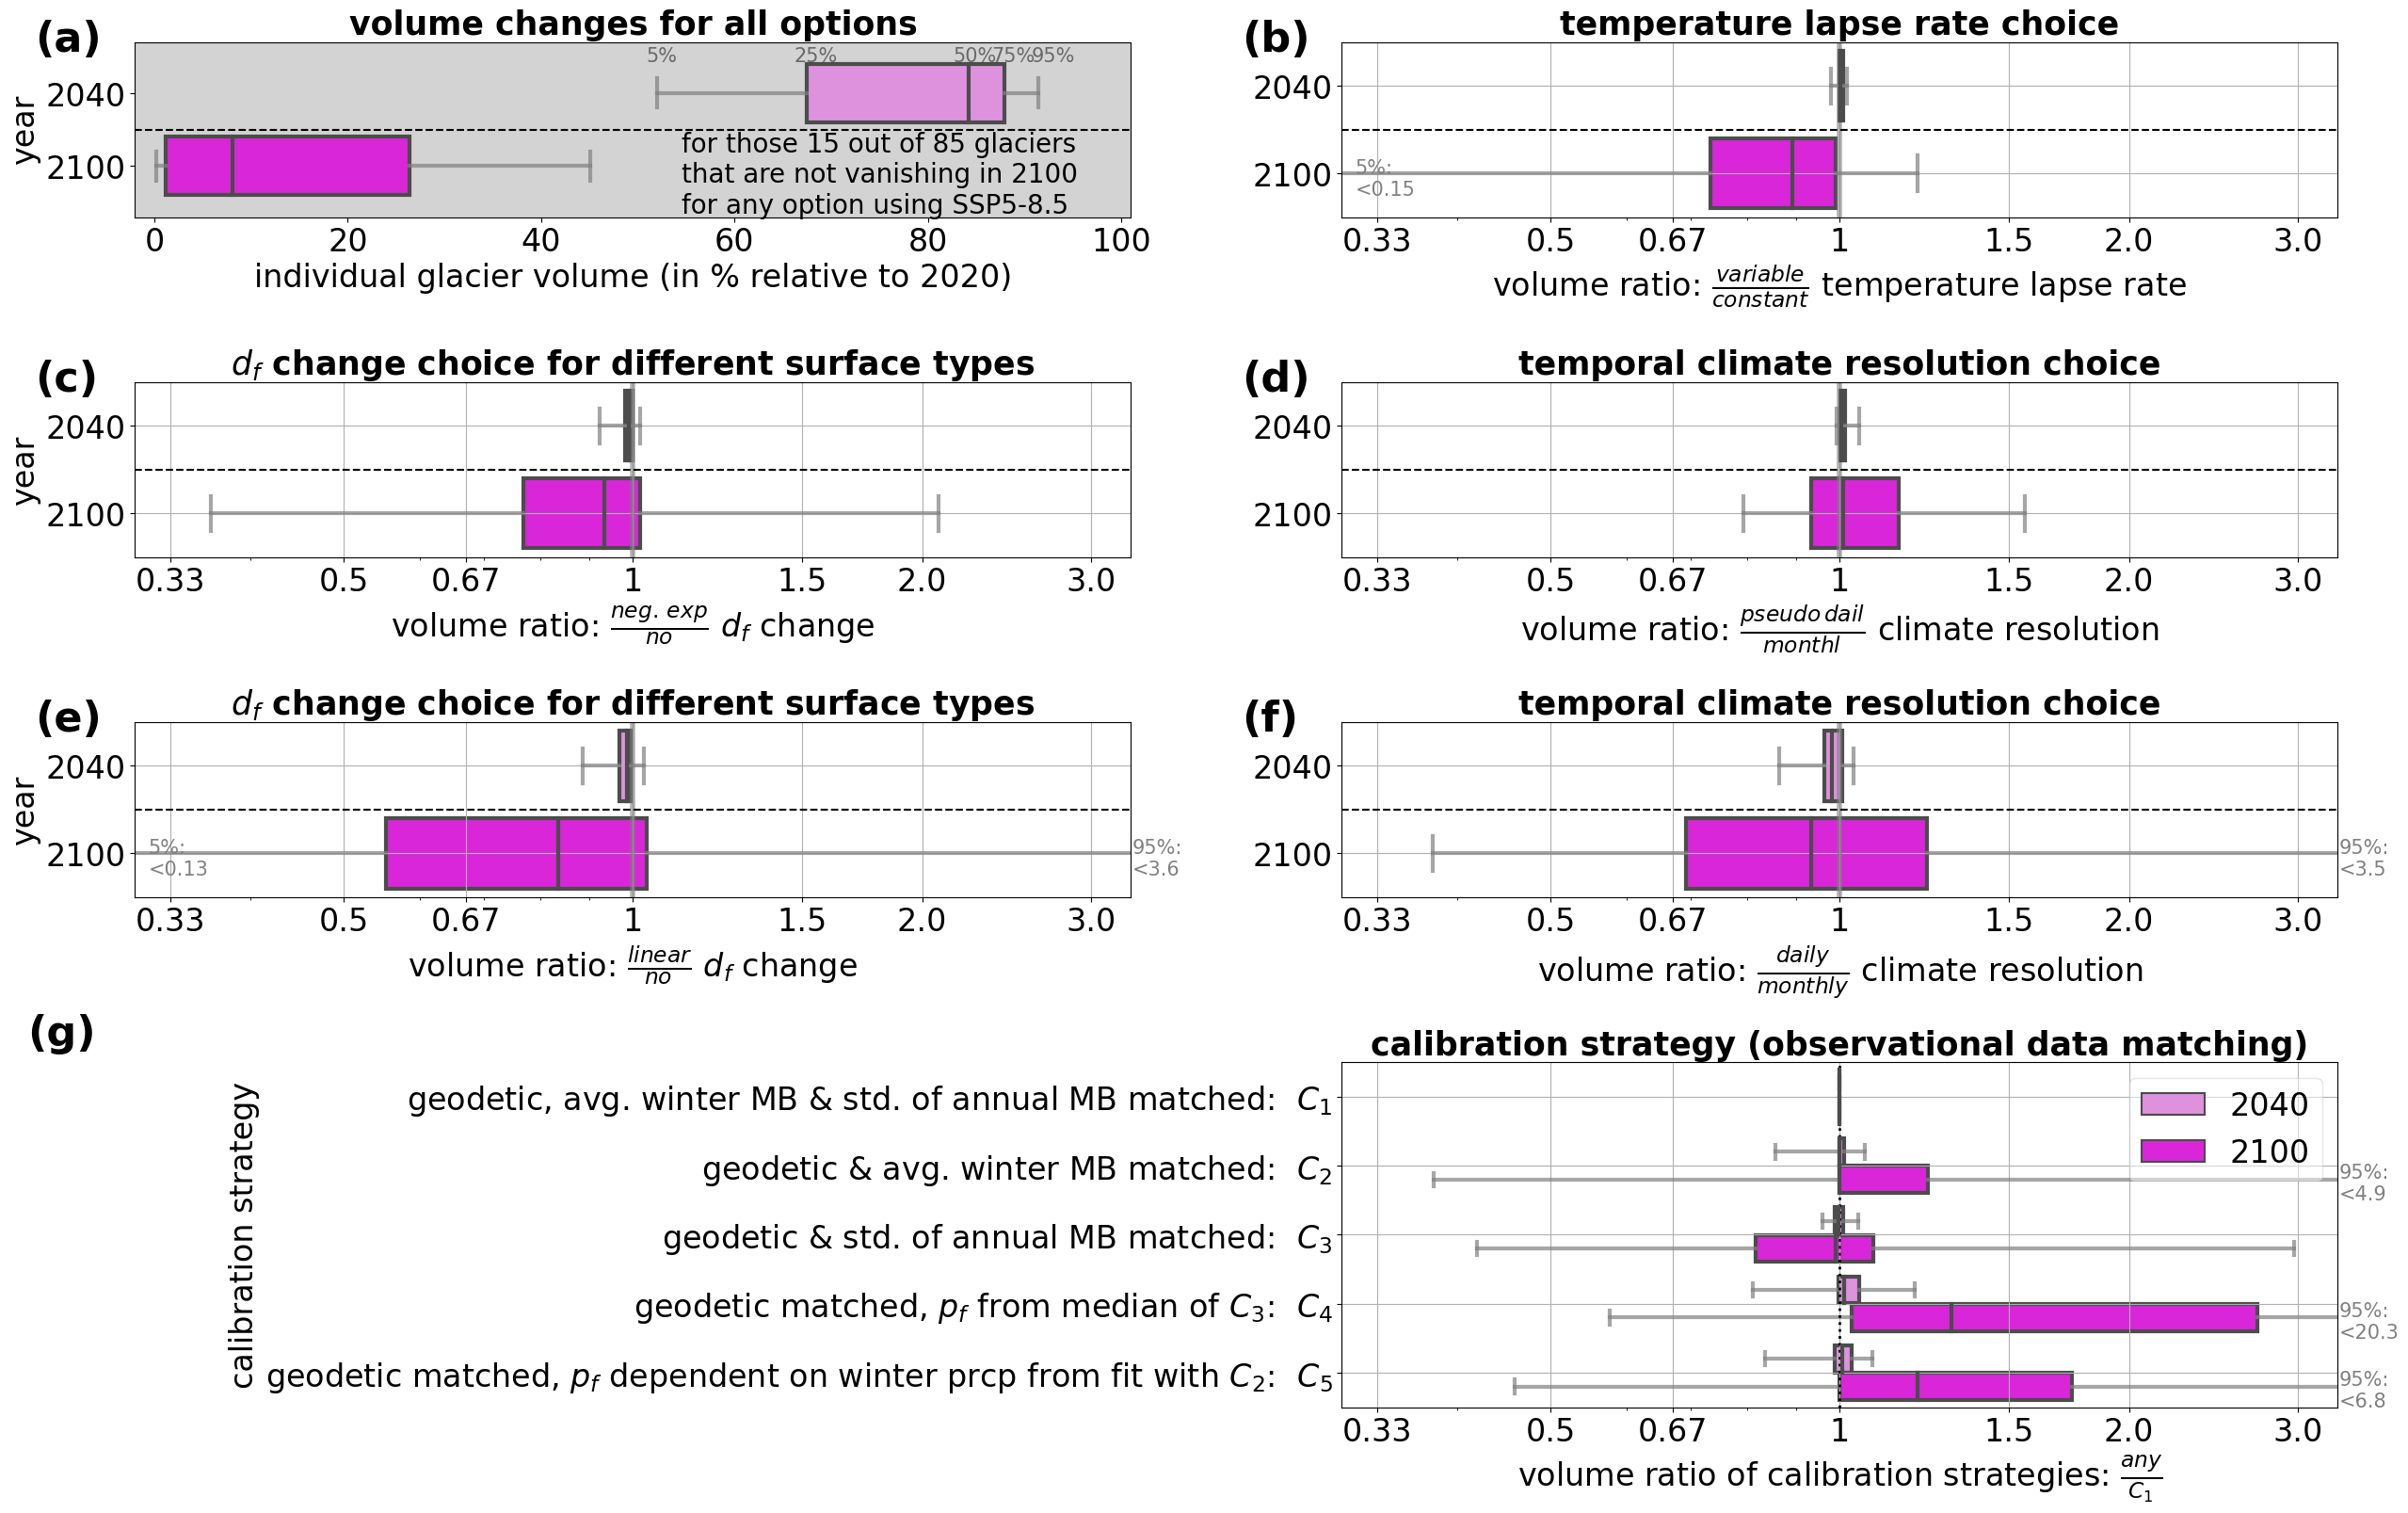

In [27]:
# overall MB and calib option influence
plt.rc('font', size=24)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5: '(f)', 6: '(g)'}

# logarithmic scale because of ratios ...
xlim0 = 0.303
xlim1 = 3.3
fs_num_dict = 32
num_text_x = -0.1
num_text_y = 0.95

violin = False
all_same_glaciers = True ## True
for all_same_glaciers in [True]: ## False
    for ssp in ['ssp126', 'ssp585']:

        if not all_same_glaciers and ssp =='ssp126':
            ssp = np.NaN
        elif not all_same_glaciers and ssp == 'ssp126':
            break

        if all_same_glaciers:
            pd_all = (100*(ds_merged.sel(time=slice(2040,2100,60))/ds_merged.sel(time=2020))).sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            ds_m = ds_merged.sel(time=slice(2040,2100,60)).copy().sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
            if ssp == 'ssp126':
                col_pal_ssp = sns.color_palette(['cyan','deepskyblue'])
            else:
                #col_pal_ssp = sns.color_palette(['magenta'])
                col_pal_ssp = sns.color_palette(['violet','magenta'])

        else:
            pd_all = (100*(ds_merged.sel(time=slice(2040,2100,60))/ds_merged.sel(time=2020))).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            col_pal_ssp = sns.color_palette(['deepskyblue', 'red'])


        pd_all['time'] = pd_all.time.astype(int).astype(str)

        c = 2
        r = 9
        if ssp == 'ssp126':
            plt.subplots(figsize=(26,16), squeeze=False)
        else:
            plt.subplots(figsize=(26,16), squeeze=False)
        

        ax0 = plt.subplot2grid((r, c), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((r, c), (0, 1), rowspan=2)
        
        
        ax1 = plt.subplot2grid((r, c), (2, 0), rowspan=2)
        ax1b = plt.subplot2grid((r, c), (4, 0), rowspan=2)

        ax3 = plt.subplot2grid((r, c), (2, 1), rowspan=2)
        ax3b = plt.subplot2grid((r, c), (4, 1), rowspan=2)

        ax4 = plt.subplot2grid((r, c), (6, 1), rowspan=3)
            
        for option_v in ['grad_type', 'mb_type_pseudo_daily','mb_type_daily','melt_f_change_neg_exp', 'melt_f_change_linear']:
            if option_v == 'melt_f_change_linear':
                tips = ['linear']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'grad_type':
                tips = ['var_an_cycle']
                default = 'cte'
                option = option_v
            elif option_v == 'mb_type_daily':
                tips = ['mb_real_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            elif option_v == 'melt_f_change_neg_exp':
                tips = ['neg_exp']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'mb_type_pseudo_daily':
                tips = ['mb_pseudo_daily_fake']   #['mb_pseudo_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            for j, tip in enumerate(tips):
                if 'melt_f_change' in option_v:
                    t = r'$d_f$ change choice for different surface types'
                    if option_v == 'melt_f_change_linear':
                        ax = ax1b
                    else:
                        ax = ax1
                    ref_v_opt = ds_merged.sel(time=slice(2040,2100,60)).volume.sel(melt_f_change = default)
                elif option_v == 'grad_type':
                    t = 'temperature lapse rate choice'
                    #ax = axs[1][0]
                    ax = ax2
                    ref_v_opt = ds_merged.sel(time=slice(2040,2100,60)).volume.sel(grad_type = default)
                elif 'mb_type' in option_v:
                    t =  'temporal climate resolution choice'
                    if option_v == 'mb_type_daily':
                        ax = ax3b
                    else:
                        ax = ax3
                    ref_v_opt = ds_merged.sel(time=slice(2040,2100,60)).volume.sel(mb_type = default)

                if all_same_glaciers:
                    ref_v_opt = ref_v_opt.sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
                ds_m_vs_ref = ds_m.volume/ref_v_opt 
                ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

                ds = ds_m_vs_ref.to_dataframe().reset_index()
                ds['time'] = ds.time.astype(str)
                ds = ds.loc[ds.volume.dropna().index]
                ds = ds.loc[ds[option] == tip]
                print(tip, t, 
                      ds.groupby(['ssp', 'time']).volume.quantile([0.25,0.5,0.75]).loc[(ssp, '2100')]) #.loc[ds.calib_type==cc]

                if violin:
                    sns.violinplot(x='volume', hue='ssp',data=ds,
                                    fliersize=0, whis=0, y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7, cut = True, ax = ax)
                else:
                    f = sns.boxplot(x='volume', hue='time', y='time', dodge = False, #hue='ssp',
                                    data=ds,
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},
                                    #legend_out=False
                                    ax = ax) #, legend=False) #, grid=True)
                ax.axvline(1.0, color='grey', linewidth=4, alpha=0.6)
                ax.set_yticklabels(['2040', '2100'])
                if option == 'melt_f_change':
                    ax.set_ylabel('year')
                else:
                    ax.set_ylabel('year', alpha = 0)
                handles, labels = ax.get_legend_handles_labels()
                # xlim1 = 2.1
                ax.legend_.remove()
                #ax.get_legend()
                p = 0.2
                if 'melt_f_change' in option_v and tip == 'linear':
                    ax.set_xlabel(r'volume ratio: $\frac{linear}{no}$ $d_f$ change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                    # any value to get the same format as ssp585 (were there are outliers ...)
                    ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<5.1', color = 'grey', fontsize=15, alpha = 0)

                        
                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if 'melt_f_change' in option_v and tip == 'neg_exp':
                    ax.set_xlabel(r'volume ratio: $\frac{neg.\,exp}{no}$ $d_f$ change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                elif option_v == 'grad_type':
                    ax.set_xlabel(r'volume ratio: $\frac{variable}{constant}$ temperature lapse rate', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_pseudo_daily_fake':
                    ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
                    # I will just add the manually later ...
                    ax.set_xlabel(r'volume ratio: $\frac{pseudo\,dail}{monthl}$ climate resolution', fontsize=24)
                    #ax.set_xlabel(r'volume ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_real_daily':
                    ax.set_xlabel(r'volume ratio: $\frac{daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')].round(1)
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if j == 0:
                    ax.set_title(t, fontsize=25, weight='bold') 
                    
                ax.set_xscale("log")
                from matplotlib.ticker import ScalarFormatter, NullFormatter
                ax.xaxis.set_major_formatter(ScalarFormatter())
                ax.xaxis.set_minor_formatter(NullFormatter())
                ax.set_xlim([xlim0,xlim1])
                ax.set_xticklabels([])
                # ERROR
                #  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.set_xticks(ticks=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0],
                              labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.grid() #axis='y')
                ax.axhline(0.5,color='black', ls = '--')
                #plt.tight_layout()
        

        #ax = axs[0][0]
        ax = ax0
        ax.set_facecolor('lightgray')
        sns.boxplot(data=pd_all,
                    x='volume', hue='time', y='time', dodge = False,
                    fliersize=0, whis = [5,95], #y = 'time', #hue_order = ['2040', '2100'],
                    linewidth=3,
                    palette=col_pal_ssp,
                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7},
                    #legend_out=False
                    ax = ax)
        qs = pd_all.groupby(['ssp', 'time']).volume.quantile([0.05,0.25,0.5,0.75,0.95]).loc[(ssp, '2040')].values
        #ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

        for p,q in enumerate(qs):
            perci = [5,25,50,75,95][p]
            if perci == 5:
                ax.text(q-1.1,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)
            elif perci == 50:
                ax.text(q-1.7,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)
            elif perci == 95:
                ax.text(q-0.7,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)

            else:
                ax.text(q-1.3,-0.43,f'{perci}%', color = 'dimgrey', fontsize=15)


        ax.set_xlabel('individual glacier volume (in % relative to 2020)', fontsize=24)
        ax.set_ylabel('year')
        ax.axhline(0.5,color='black', ls = '--')
        ax.set_xlim([-2,101])
        ax.set_ylim([1.7,-0.7])
        


        p = 0
        ax.set_title('volume changes for all options', fontsize=25,weight='bold')

        if not all_same_glaciers:
            pass
            ax.legend(bbox_to_anchor=(0.4,0.2))

        else:
            len_rgis=len(working_dict[f'2100_{ssp}'])
            total = pd_len_rgis['all'][0]
            if ssp == 'ssp126':
                ax.text(54.5, 1.64,f'for those {len_rgis} out of {total} glaciers\nthat are not vanishing in 2100 \nfor any option using SSP1-2.6',
                        fontsize=20)
            else:
                ax.text(54.5, 1.64,f'for those {len_rgis} out of {total} glaciers\nthat are not vanishing in 2100 \nfor any option using SSP5-8.5',
                        fontsize=20)
            ax.legend_.remove()

        calib_types_nice = [r'geodetic, avg. winter MB & std. of annual MB matched:$\,\,\,\,C_1$',
                            r'geodetic & avg. winter MB matched:$\,\,\,\,C_2$',
                            r'geodetic & std. of annual MB matched:$\,\,\,\,C_3$',
                            r'geodetic matched, $p_f$ from median of $C_3$:$\,\,\,\,C_4$',
                            r'geodetic matched, $p_f$ dependent on winter prcp from fit with $C_2$:$\,\,\,\,C_5$']
        w_rgis = working_dict[f'2100_{ssp}']
        ds= ds_merged_vs_ref_each_calib_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).sel(ssp=ssp).to_dataframe().reset_index()
        ds['time'] = ds['time'].astype('int')
            
        plt.tight_layout()

        ax = ax4
        #ax = axs[2][1]
        f = sns.boxplot(y='calib_type', x='volume', hue='time', data=ds, palette=col_pal_ssp, #kind='box',
                        fliersize=0, whis=[5,95],
                        #col = 'time',
                        linewidth=3, 
                        #aspect=1.6, #order = calib_types,
                        #legend_out=False,
                        saturation=0.7, ax=ax,
                       capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7}) #, grid=True)

        #if yr == 2040:
        #    a.set_xlim([0.0,0.1])
        #elif yr==2100:
        #ax.set_xlim([0.2,1.8])
        ax.legend(loc='upper right', framealpha = 0.5)
        ax.grid()

        ax.set_xlabel(r'volume ratio of calibration strategies: $\frac{any}{C_1}$')
        ax.axvline(1, linewidth=2, ls=':', color = 'black')
        #xlim1 = 2.8
        #ax.set_xlim([0.15, xlim1]) # 0.01
        ax.set_xscale("log")
        from matplotlib.ticker import ScalarFormatter, NullFormatter
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_xlim([xlim0,xlim1])
        ax.set_xticklabels([])
        ax.set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
        
        ax.set_yticklabels(calib_types_nice)
        ax.set_ylabel('calibration strategy')
        ax.set_title('calibration strategy (observational data matching)', fontsize=25,weight='bold') 
        
        for jj, cc in enumerate(calib_types):
            q05 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, 2100)]
            if q05 <= xlim0:
                ax.text(xlim0+0.01,jj+0.5,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=20)
            q95 = ds.loc[ds.calib_type==cc].groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, 2100)].round(1)
            if q95 >= xlim1:
                ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                # make sure that ssp126 and ssp585 have the same format, need to plot it with alpha = 0
                # just any value
        ax.text(xlim1+0.01,jj+0.5,r'95%:'+f'\n<20.1', color = 'grey', fontsize=15, alpha = 0)
        
        # has to come after tight_layout ...
        ax0.text(num_text_x,num_text_y,'(a)',weight='bold',
                    fontsize=fs_num_dict, transform=ax0.transAxes)
        ax2.text(num_text_x,num_text_y,'(b)',weight='bold',
                    fontsize=fs_num_dict, transform=ax2.transAxes)
        
        ax1.text(num_text_x,num_text_y,'(c)',weight='bold',
                    fontsize=fs_num_dict, transform=ax1.transAxes)
        ax1b.text(num_text_x,num_text_y,'(e)',weight='bold',
                    fontsize=fs_num_dict, transform=ax1b.transAxes)

        ax3.text(num_text_x,num_text_y,'(d)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3.transAxes)
        ax3b.text(num_text_x,num_text_y,'(f)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3b.transAxes)

        ax4.text(num_text_x-1.22,num_text_y+0.1,'(g)',weight='bold',
                    fontsize=fs_num_dict, transform=ax4.transAxes)    
        
    
        if ssp == 'ssp126':
            plt.savefig(f'{fig_path}/fig_6_rel_vol_to_ref_timodel_calib_option_{ensemble}_common_running_{ssp}_w_pseudo_daily_fake.pdf', bbox_inches='tight')
        else:
            plt.savefig(f'{fig_path}/figures_supplements/fig_S13_rel_vol_to_ref_timodel_calib_option_{ensemble}_common_running_{ssp}_w_pseudo_daily_fake.pdf', bbox_inches='tight')


#### temperature lapse rate choice most "important" -> get the quantitative numbers

In [28]:
print(1- 0.616385, 1- 0.810614, 1-0.961048)

0.38361500000000004 0.18938600000000005 0.03895199999999999


**Only for Supplementary Informations -> compare pseudo-daily changing std  (with temperature standard deviations taken from GCMs)**

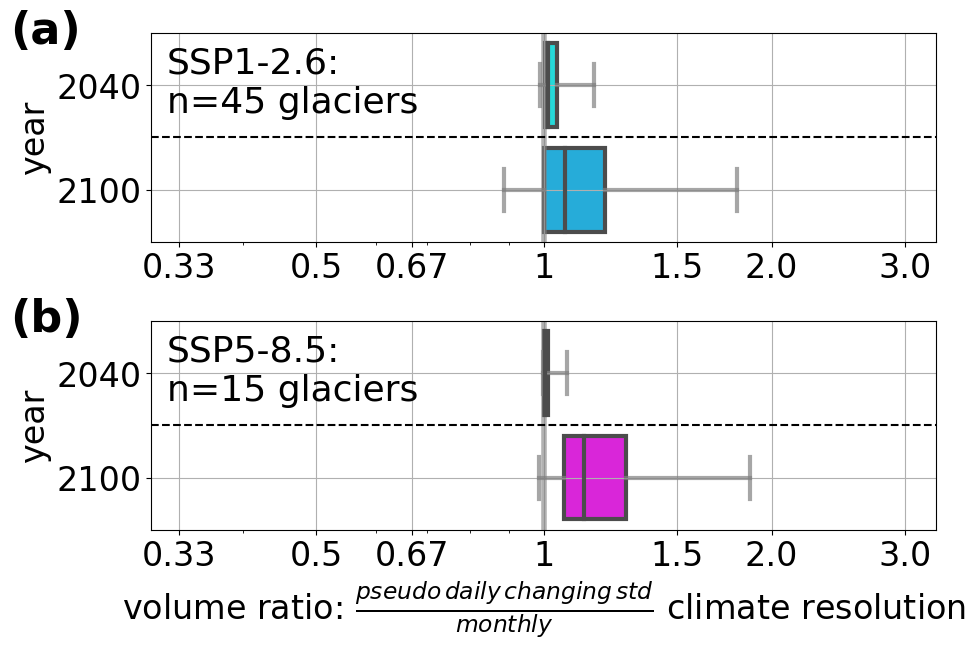

In [62]:
### ONLY COMPARE pseudo daily !!! 
# overall MB and calib option influence
plt.rc('font', size=24)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5: '(f)', 6: '(g)'}

# logarithmic scale because of ratios ...
xlim0 = 0.303
xlim1 = 3.3
fs_num_dict = 32
num_text_x = -0.18
num_text_y = 0.95

violin = False
all_same_glaciers = True ## True
ds_merged_c = ds_merged_gcms.median(dim='gcm') #ds_merged.isel(calib_type=-1)

for all_same_glaciers in [True]: ## False
    plt.figure(figsize=(10,7)) #, squeeze=False)
    for ssp in ['ssp126', 'ssp585']:

        if not all_same_glaciers and ssp =='ssp126':
            ssp = np.NaN
        elif not all_same_glaciers and ssp == 'ssp126':
            break

        if all_same_glaciers:
            pd_all = (100*(ds_merged_c.sel(time=slice(2040,2100,60))/ds_merged_c.sel(time=2020))).sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            ds_m = ds_merged_c.sel(time=slice(2040,2100,60)).copy().sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
            if ssp == 'ssp126':
                col_pal_ssp = sns.color_palette(['cyan','deepskyblue'])
            else:
                #col_pal_ssp = sns.color_palette(['magenta'])
                col_pal_ssp = sns.color_palette(['violet','magenta'])

        else:
            pd_all = (100*(ds_merged_c.sel(time=slice(2040,2100,60))/ds_merged_c.sel(time=2020))).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            col_pal_ssp = sns.color_palette(['deepskyblue', 'red'])

        pd_all['time'] = pd_all.time.astype(int).astype(str)

        c = 1
        r = 6
        if ssp == 'ssp126':
            axi = plt.subplot(211)
        else:
            axi = plt.subplot(212)

            
        for option_v in ['mb_type_pseudo_daily']: #, 'mb_type_pseudo_daily_fake',
            if option_v == 'melt_f_change_linear':
                tips = ['linear']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'grad_type':
                tips = ['var_an_cycle']
                default = 'cte'
                option = option_v
            elif option_v == 'mb_type_daily':
                tips = ['mb_real_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            elif option_v == 'melt_f_change_neg_exp':
                tips = ['neg_exp']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'mb_type_pseudo_daily':
                tips = ['mb_pseudo_daily']   #['mb_pseudo_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            elif option_v == 'mb_type_pseudo_daily_fake':
                tips = ['mb_pseudo_daily_fake']   #['mb_pseudo_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            for j, tip in enumerate(tips):
                if 'melt_f_change' in option_v:
                    t = r'$d_f$ change choice for different surface types'
                    if option_v == 'melt_f_change_linear':
                        ax = ax1b
                    else:
                        ax = ax1
                    ref_v_opt = ds_merged_c.sel(time=slice(2040,2100,60)).volume.sel(melt_f_change = default)
                elif option_v == 'grad_type':
                    t = 'temperature lapse rate choice'
                    #ax = axs[1][0]
                    ax = ax2
                    ref_v_opt = ds_merged_c.sel(time=slice(2040,2100,60)).volume.sel(grad_type = default)
                elif 'mb_type' in option_v:
                    t =  'temporal climate resolution choice'
                    ax = axi
                    ref_v_opt = ds_merged_c.sel(time=slice(2040,2100,60)).volume.sel(mb_type = default)

                if all_same_glaciers:
                    ref_v_opt = ref_v_opt.sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
                ds_m_vs_ref = ds_m.volume/ref_v_opt 
                ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

                ds = ds_m_vs_ref.to_dataframe().reset_index()
                ds['time'] = ds.time.astype(str)
                ds = ds.loc[ds.volume.dropna().index]
                ds = ds.loc[ds[option] == tip]
                if violin:
                    sns.violinplot(x='volume', hue='ssp',data=ds,
                                    fliersize=0, whis=0, y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7, cut = True, ax = ax)
                else:
                    f = sns.boxplot(x='volume', hue='time', y='time', dodge = False, #hue='ssp',
                                    data=ds,
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},
                                    #legend_out=False
                                    ax = ax) #, legend=False) #, grid=True)
                ax.axvline(1.0, color='grey', linewidth=4, alpha=0.6)
                ax.set_yticklabels(['2040', '2100'])
                #if option == 'melt_f_change':
                ax.set_ylabel('year')
                #else:
                #    ax.set_ylabel('year', alpha = 0)
                handles, labels = ax.get_legend_handles_labels()
                # xlim1 = 2.1
                ax.legend_.remove()
                #ax.get_legend()
                p = 0.2
                if 'melt_f_change' in option_v and tip == 'linear':
                    ax.set_xlabel(r'volume ratio: $\frac{yes\,(linear)}{no}$ $d_f$ change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                    # any value to get the same format as ssp585 (were there are outliers ...)
                    ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<5.1', color = 'grey', fontsize=15, alpha = 0)

                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if 'melt_f_change' in option_v and tip == 'neg_exp':
                    ax.set_xlabel(r'volume ratio: $\frac{yes\,(neg\_exp)}{no}$ $d_f$ change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                elif option_v == 'grad_type':
                    ax.set_xlabel(r'volume ratio: $\frac{variable}{constant}$ temperature lapse rate', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_pseudo_daily':
                    ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
                    # I will just add the manually later ...
                    ax.set_xlabel(r'volume ratio: $\frac{pseudo\,daily\,changing\,std}{monthly}$ climate resolution', fontsize=24)
                    #ax.set_xlabel(r'volume ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_pseudo_daily_fake':
                    ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
                    # I will just add the manually later ...
                    ax.set_xlabel(r'volume ratio: $\frac{pseudo\,daily}{monthly}$ climate resolution', fontsize=24)
                    #ax.set_xlabel(r'volume ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_real_daily':
                    ax.set_xlabel(r'volume ratio: $\frac{daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')].round(1)
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                #if j == 0:
                #    ax.set_title(t, fontsize=25, weight='bold') 
                    
                ax.set_xscale("log")
                from matplotlib.ticker import ScalarFormatter, NullFormatter
                ax.xaxis.set_major_formatter(ScalarFormatter())
                ax.xaxis.set_minor_formatter(NullFormatter())
                ax.set_xlim([xlim0,xlim1])
                ax.set_xticklabels([])
                # ERROR
                #  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.set_xticks(ticks=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0],
                              labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.grid() #axis='y')
                ax.axhline(0.5,color='black', ls = '--')
                #plt.tight_layout()
        
        
        # has to come after tight_layout ...
        #plt.suptitle(t)# +r': only calibration option $C_5$')

        
        plt.tight_layout()
        if ssp == 'ssp126':
            ax.text(num_text_x,num_text_y,'(a)',weight='bold',
                        fontsize=fs_num_dict, transform=ax.transAxes)
            ax.set_xlabel('')
            ax.text(0.02,0.62,'SSP1-2.6:\nn=45 glaciers',#weight='bold',
                        fontsize=fs_num_dict-6, transform=ax.transAxes)
        else:
            ax.text(num_text_x,num_text_y,'(b)',weight='bold',
                        fontsize=fs_num_dict, transform=ax.transAxes)
            ax.text(0.02,0.62,'SSP5-8.5:\nn=15 glaciers',#weight='bold',
                        fontsize=fs_num_dict-6, transform=ax.transAxes)

        
    plt.savefig(f'{fig_path}/figures_supplements/fig_S14_temp_clim_comp_{ensemble}_common_running_both_ssps_only_pseudo_daily.pdf',
                bbox_inches='tight')


### Fig. S15: assess whether one calibration option results in more/less spread between the MB model options

**Spread of MB model types for the different calib options ... How much different are the MB model types differeing between each other in the different calibration options...**


method:
- compute the volume ratio compard to the most default mb_monthly_cte run: -> `ds_merged_vs_ref_each_option`
- just plot it against the calib options (depending on ssp and two time points?)

In [29]:
calib_type_short = [r'$C_1$', r'$C_2$',r'$C_3$',r'$C_4$',r'$C_5$']

In [30]:
ref_vol_option = ds_merged_gcms_sel.median(dim='gcm').volume.sel(mb_type='mb_monthly').sel(grad_type='cte').sel(melt_f_change='False')#.sel(calib_type='calib_only_geod_temp_b_0_pf_fit_via_winter_mb')
ds_merged_vs_ref_each_option = ds_merged.volume/ref_vol_option 
ds_merged_vs_ref_each_option = ds_merged_vs_ref_each_option.where(ds_merged_vs_ref_each_option < np.inf, drop=True) 
ds_merged_vs_ref_each_option = ds_merged_vs_ref_each_option.where(ds_merged_vs_ref_each_option > 1e-7, np.NaN)

#, ds_merged_vs_ref_each_option.values)

In [31]:
ssp_nice = {'ssp126': 'SSP1-2.6', 'ssp585':'SSP5-8.5'}

ssp126              volume
time               
2040 0.25  0.015834
     0.50  0.031416
     0.75  0.068786
2100 0.25  0.101459
     0.50  0.208600
     0.75  0.354673



ssp585              volume
time               
2040 0.25  0.013638
     0.50  0.018358
     0.75  0.028306
2100 0.25  0.173361
     0.50  0.267443
     0.75  0.406141





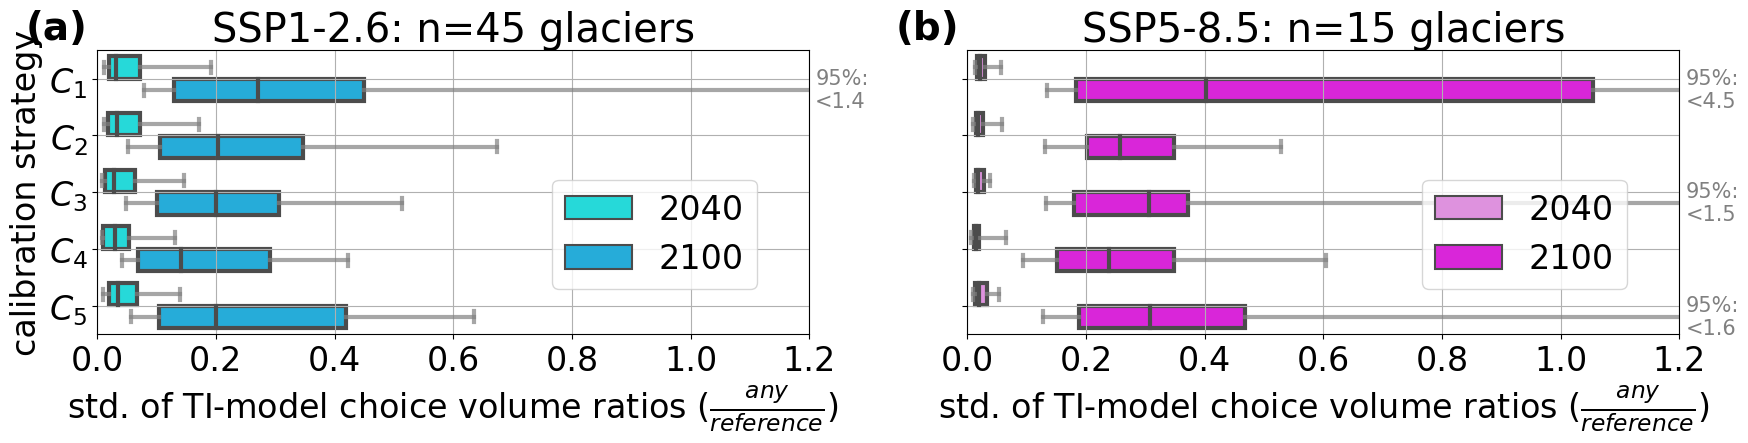

In [32]:
num_text_x = -0.1
num_text_y = 1.04
xlim1 = 1.2
fig, axs = plt.subplots(1,2, figsize=(18,5), sharey=True)
#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
for ax, ssp in zip(axs, ['ssp126', 'ssp585']):
    w_rgis = working_dict[f'2100_{ssp}']
    if ssp == 'ssp126':
        col_pal_ssp = sns.color_palette(['cyan','deepskyblue'])
        ax.text(num_text_x,num_text_y,'(a)',weight='bold',
                    fontsize=28, transform=ax.transAxes)
    else:
        #col_pal_ssp = sns.color_palette(['magenta'])
        col_pal_ssp = sns.color_palette(['violet','magenta'])
        ax.text(num_text_x,num_text_y,'(b)',weight='bold',
                    fontsize=28, transform=ax.transAxes)
    ds_std_ = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).sel(ssp=ssp).to_dataframe().reset_index()
    ds_std = ds_std_.groupby(['calib_type', 'ssp', 'time', 'rgi_id']).volume.std().reset_index()
    #ds_spread = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).to_dataframe().reset_index()
    ds_std['time'] = ds_std['time'].astype('int')
    print(ssp, ds_std.groupby(['time']).quantile([0.25,0.5,0.75]))
    print('\n')
    print()
    f = sns.boxplot(y='calib_type', x='volume', hue='time', data=ds_std, palette=col_pal_ssp, #kind='box',
                    fliersize=0, whis=[5,95], order = calib_types,
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7},
                    #col = 'time',
                    linewidth=3, 
                    #aspect=1.6, #order = calib_types,
                    #legend_out=False,
                    saturation=0.7, ax=ax) #, grid=True)
    for jj,calib_type in enumerate(calib_types):
        q95 = ds_std.groupby(['calib_type', 'time']).quantile(0.95).loc[(calib_type, 2100)].volume.round(2)
        if q95 >= xlim1:
            ax.text(xlim1+0.01,0.5+jj,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)

    #if yr == 2040:
    #    a.set_xlim([0.0,0.1])
    #elif yr==2100:
    ax.set_xlim([0,xlim1])
    ax.legend(loc='lower right', bbox_to_anchor=(0.95,0.1))
    ax.set_yticklabels(calib_type_short)
    ax.set_ylabel('calibration strategy')
    ax.grid()
    if ax != axs[0]:
        ax.set_ylabel('')
    ax.set_title(f'{ssp_nice[ssp]}: n={len(w_rgis)} glaciers')
    ax.set_xlabel(r'std. of TI-model choice volume ratios '+ r'($\frac{any}{reference}$)')


plt.tight_layout()
plt.savefig(f'{fig_path}/figures_supplements/fig_S15_std_volume_ratios_mb_options_for_calib_options_simple_boxplot_{ensemble}_common_glaciers_w_fake_pseudo_daily.pdf',
            pad_inches=0.05, bbox_inches='tight')


In [33]:
ssp = 'ssp126'
w_rgis = working_dict[f'2100_{ssp}']

ds_std_ = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).sel(ssp=ssp).to_dataframe().reset_index()
ds_std = ds_std_.groupby(['calib_type', 'ssp', 'time', 'rgi_id']).volume.std().reset_index()
#ds_spread = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).to_dataframe().reset_index()
ds_std['time'] = ds_std['time'].astype('int')

ds_std.groupby(['calib_type', 'ssp', 'time']).quantile([0.25,0.5,0.75]).T

calib_type calib_geod_opt_std_temp_b_0                                        \
ssp                             ssp126                                         
time                              2040                        2100             
                                  0.25    0.50      0.75      0.25      0.50   
volume                        0.013777  0.0289  0.064274  0.099976  0.199432   

calib_type           calib_geod_opt_winter_mb_approx_std                      \
ssp                                               ssp126                       
time                                                2040                       
                0.75                                0.25      0.50      0.75   
volume      0.306718                            0.020007  0.031416  0.071386   

calib_type            ... calib_only_geod_temp_b_0_pf_cte_via_std            \
ssp                   ...                                  ssp126             
time            2100  ...                                    2040      2100   
                0.25  ...                                    0.75      0.25   
volume      0.129908  ...                                0.054334  0.069397   

calib_type                     calib_only_geod_temp_b_0_pf_fit_via_winter_mb  \
ssp                                                                   ssp126   
time                                                                    2040   
                0.50      0.75                                          0.25   
volume      0.140649  0.290558                                      0.020196   

calib_type                                                    
ssp                                                           
time                                2100                      
                0.50      0.75      0.25      0.50      0.75  
volume      0.035569  0.067826  0.104241  0.199433  0.419163  

[1 rows x 30 columns]

### Additional Analysis and Figures that did not make it into the manuscript or supplements: 

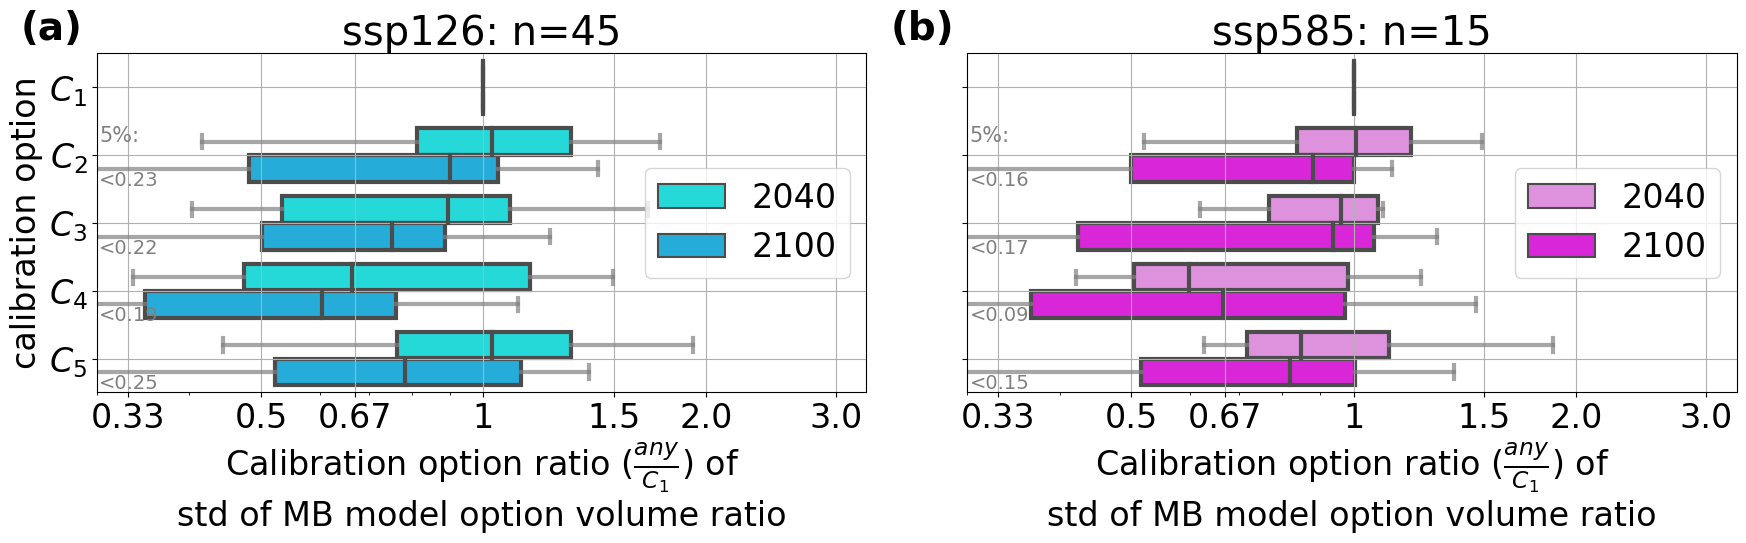

In [79]:
interp = 'higher' #'midpoint'
num_text_x = -0.1
num_text_y = 1.04
xlim0 = 0.3
xlim1 = 3.3


fig, axs = plt.subplots(1,2, figsize=(18,6), sharey=True)
#ds_spread['volume'] = np.abs(ds_spread.volume-1) #ds_spread.volume.
for ax, ssp in zip(axs, ['ssp126', 'ssp585']):
    w_rgis = working_dict[f'2100_{ssp}']
    if ssp == 'ssp126':
        col_pal_ssp = sns.color_palette(['cyan','deepskyblue'])
        ax.text(num_text_x,num_text_y,'(a)',weight='bold',
                    fontsize=28, transform=ax.transAxes)
    else:
        #col_pal_ssp = sns.color_palette(['magenta'])
        col_pal_ssp = sns.color_palette(['violet','magenta'])
        ax.text(num_text_x,num_text_y,'(b)',weight='bold',
                    fontsize=28, transform=ax.transAxes)
    ds_std_ = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).sel(ssp=ssp).to_dataframe().reset_index()
    # ds_std = ds_std_.groupby(['calib_type', 'ssp', 'time', 'rgi_id']).volume.std().reset_index()
    ds_ratio_std = ds_std_.groupby(['calib_type', 'ssp', 'time', 'rgi_id']).volume.std().to_xarray()
    ds_ratio_std = ds_ratio_std/ds_ratio_std.sel(calib_type='calib_geod_opt_winter_mb_approx_std')
    pd_ratio_std = ds_ratio_std.to_dataframe().reset_index()
    #ds_spread = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).to_dataframe().reset_index()
    pd_ratio_std['time'] = pd_ratio_std['time'].astype('int')
    f = sns.boxplot(y='calib_type', x='volume', hue='time', data=pd_ratio_std, palette=col_pal_ssp, #kind='box',
                    fliersize=0, whis=(5,95), order = calib_types,
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7},
                    #col = 'time',
                    linewidth=3, 
                    #aspect=1.6, #order = calib_types,
                    #legend_out=False,
                    saturation=0.7, ax=ax) #, grid=True)


    #if yr == 2040:
    #    a.set_xlim([0.0,0.1])
    #elif yr==2100:
    ax.set_xscale("log")
    from matplotlib.ticker import ScalarFormatter, NullFormatter
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xlim([xlim0,xlim1])
    ax.set_xticklabels([])
    ax.set_xticks([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0],
                  labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
    ax.text(xlim0+0.002,0.8,r'5%:', color = 'grey', fontsize=15)
    for jj,calib_type in enumerate(calib_types):
        
        # actually seaborn/matplotlib seems to estimate the quantiles via 'higher' interpolation
        # vs pandas does per default a linear interpolation ... 
        # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.quantile.html
        # should maybe change this..
        q05 = pd_ratio_std.groupby(['calib_type', 'time']).quantile(0.05, interpolation=interp).loc[(calib_type, 2040)].volume.round(2)
        if q05 <= xlim0:
            ax.text(xlim0+0.002,0.05+jj,f'<{q05:.2f}', color = 'grey', fontsize=14)
        
        q05 = pd_ratio_std.groupby(['calib_type', 'time']).quantile(0.05, interpolation=interp).loc[(calib_type, 2100)].volume.round(2)
        if q05 <= xlim0:
            ax.text(xlim0+0.002,0.45+jj,f'<{q05:.2f}', color = 'grey', fontsize=14)
        
        #q95 = pd_ratio_std.groupby(['calib_type', 'time']).quantile(0.95).loc[(calib_type, 2100)].volume.round(2)
        #if q95 >= xlim0:
        #    ax.text(xlim0+0.002,0.45+jj,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=14)
    #ax.set_xlim([xlim0,xlim1])
    ax.legend(loc='center right') #, bbox_to_anchor=(0.95,0.1))
    ax.set_yticklabels(calib_type_short)
    ax.set_ylabel('calibration option')
    ax.grid()
    if ax != axs[0]:
        ax.set_ylabel('')
    #    ax.legend_.remove()
    ax.set_title(f'{ssp}: n={len(w_rgis)}')
    #ax.set_xlabel(r'ratio ($\frac{any}{C_1}$) of std of TI-model option volume ratios ($\frac{any}{reference}$)')
    ax.set_xlabel(r'Calibration option ratio ($\frac{any}{C_1}$) of'+f'\nstd of MB model option volume ratio')

    #ax.axvline(1, linewidth=2, ls=':', color = 'black')

plt.tight_layout()
#plt.savefig(f'{fig_path}/ratios_of_std_volume_ratios_mb_options_for_calib_options_simple_boxplot_{ensemble}_common_glaciers_w_fake_pseudo_daily.pdf',
#            pad_inches=0.05, bbox_inches='tight')


In [80]:
ssp = 'ssp126'
w_rgis = working_dict[f'2100_{ssp}']

ds_std_ = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).sel(ssp=ssp).to_dataframe().reset_index()
ds_ratio_std = ds_std_.groupby(['calib_type', 'ssp', 'time', 'rgi_id']).volume.std().to_xarray()
ds_ratio_std = ds_ratio_std/ds_ratio_std.sel(calib_type='calib_geod_opt_winter_mb_approx_std')
pd_ratio_std = ds_ratio_std.to_dataframe().reset_index()
#ds_spread = ds_merged_vs_ref_each_option.sel(time=slice(2040,2100,60)).sel(rgi_id =w_rgis).to_dataframe().reset_index()
pd_ratio_std['time'] = pd_ratio_std['time'].astype('int')

pd_ratio_std.loc[pd_ratio_std.time==2100].groupby(['calib_type', 'ssp', 'time']).quantile([0.5])

,,,,volume
calib_type,ssp,time,,
calib_geod_opt_std_temp_b_0,ssp126,2100,0.5,0.751440
calib_geod_opt_winter_mb_approx_std,ssp126,2100,0.5,1.000000
calib_geod_opt_winter_mb_temp_b_0,ssp126,2100,0.5,0.899812
calib_only_geod_temp_b_0_pf_cte_via_std,ssp126,2100,0.5,0.604235
calib_only_geod_temp_b_0_pf_fit_via_winter_mb,ssp126,2100,0.5,0.782501


#### Compare all temporal climate resolution option projections on one plot:

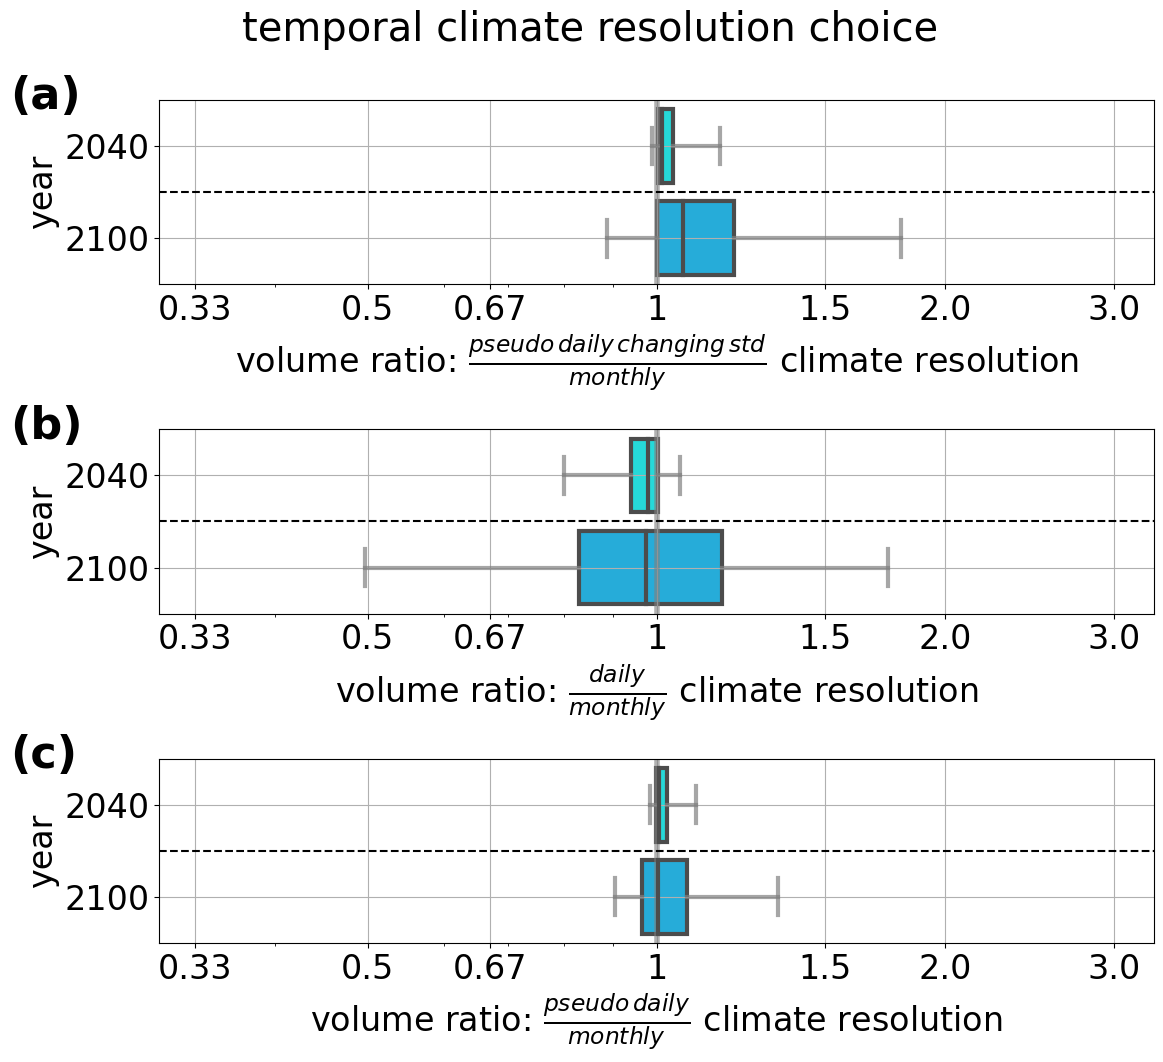

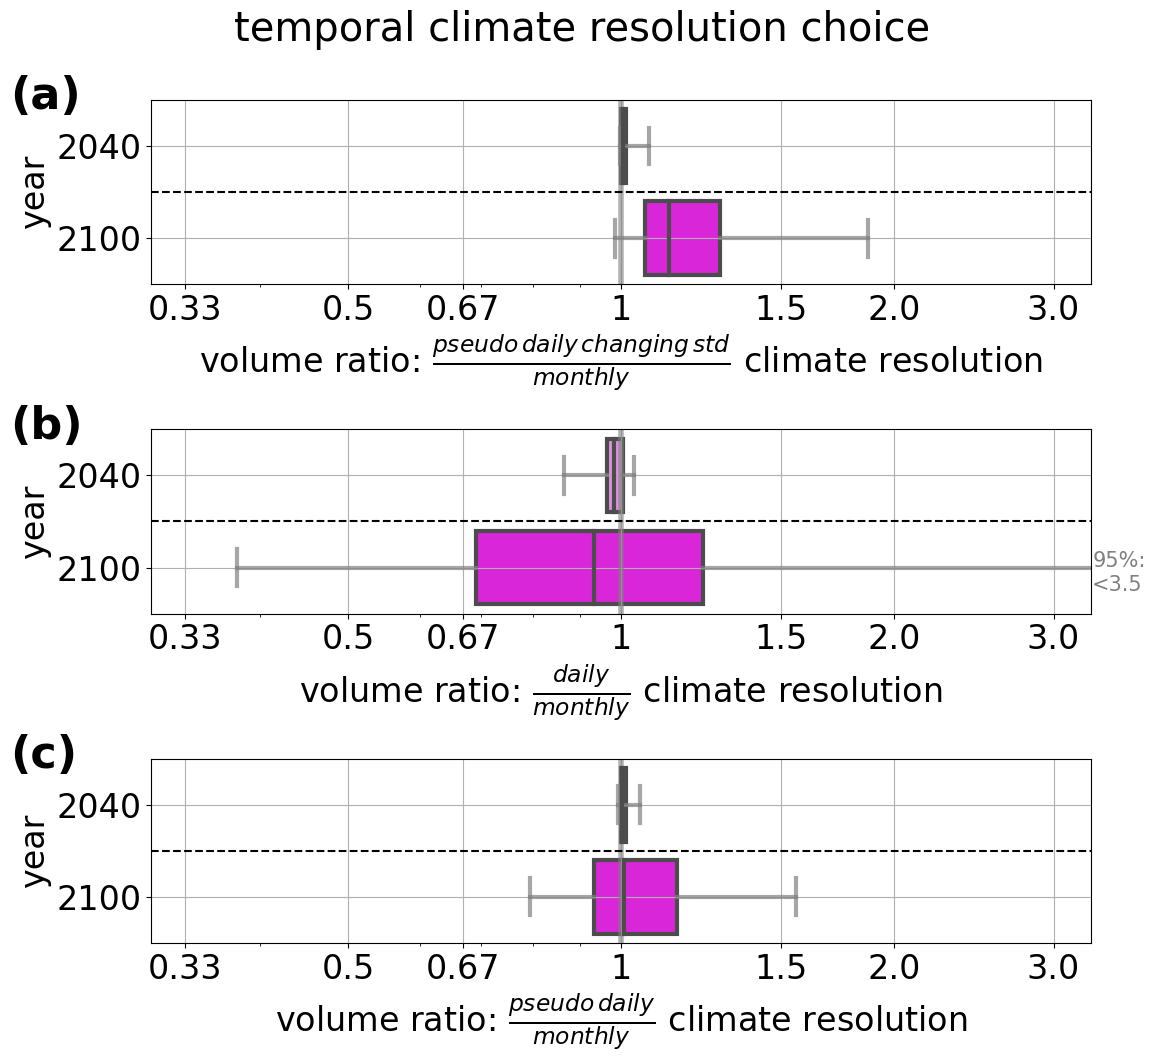

In [63]:
### ONLY COMPARE pseudo daily !!! 
# overall MB and calib option influence
plt.rc('font', size=24)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5: '(f)', 6: '(g)'}

# logarithmic scale because of ratios ...
xlim0 = 0.303
xlim1 = 3.3
fs_num_dict = 32
num_text_x = -0.15
num_text_y = 0.95

violin = False
all_same_glaciers = True ## True
ds_merged_c = ds_merged_gcms.median(dim='gcm') #ds_merged.isel(calib_type=-1)

for all_same_glaciers in [True]: ## False
    for ssp in ['ssp126', 'ssp585']:

        if not all_same_glaciers and ssp =='ssp126':
            ssp = np.NaN
        elif not all_same_glaciers and ssp == 'ssp126':
            break

        if all_same_glaciers:
            pd_all = (100*(ds_merged_c.sel(time=slice(2040,2100,60))/ds_merged_c.sel(time=2020))).sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            ds_m = ds_merged_c.sel(time=slice(2040,2100,60)).copy().sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
            if ssp == 'ssp126':
                col_pal_ssp = sns.color_palette(['cyan','deepskyblue'])
            else:
                #col_pal_ssp = sns.color_palette(['magenta'])
                col_pal_ssp = sns.color_palette(['violet','magenta'])

        else:
            pd_all = (100*(ds_merged_c.sel(time=slice(2040,2100,60))/ds_merged_c.sel(time=2020))).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            col_pal_ssp = sns.color_palette(['deepskyblue', 'red'])

        pd_all['time'] = pd_all.time.astype(int).astype(str)

        c = 1
        r = 6
        if ssp == 'ssp126':
            plt.subplots(figsize=(12,11), squeeze=False)
        else:
            plt.subplots(figsize=(12,11), squeeze=False)
        

        ax2 = plt.subplot2grid((r, c), (0, 0), rowspan=2)
        ax3 = plt.subplot2grid((r, c), (2, 0), rowspan=2)
        ax3b = plt.subplot2grid((r, c), (4, 0), rowspan=2)

            
        for option_v in ['mb_type_pseudo_daily', 'mb_type_pseudo_daily_fake',
                         'mb_type_daily']:
            if option_v == 'melt_f_change_linear':
                tips = ['linear']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'grad_type':
                tips = ['var_an_cycle']
                default = 'cte'
                option = option_v
            elif option_v == 'mb_type_daily':
                tips = ['mb_real_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            elif option_v == 'melt_f_change_neg_exp':
                tips = ['neg_exp']
                default = 'False'
                option = 'melt_f_change'
            elif option_v == 'mb_type_pseudo_daily':
                tips = ['mb_pseudo_daily']   #['mb_pseudo_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            elif option_v == 'mb_type_pseudo_daily_fake':
                tips = ['mb_pseudo_daily_fake']   #['mb_pseudo_daily']
                default = 'mb_monthly'
                option = 'mb_type'
            for j, tip in enumerate(tips):
                if 'melt_f_change' in option_v:
                    t = r'$d_f$ change choice for different surface types'
                    if option_v == 'melt_f_change_linear':
                        ax = ax1b
                    else:
                        ax = ax1
                    ref_v_opt = ds_merged_c.sel(time=slice(2040,2100,60)).volume.sel(melt_f_change = default)
                elif option_v == 'grad_type':
                    t = 'temperature lapse rate choice'
                    #ax = axs[1][0]
                    ax = ax2
                    ref_v_opt = ds_merged_c.sel(time=slice(2040,2100,60)).volume.sel(grad_type = default)
                elif 'mb_type' in option_v:
                    t =  'temporal climate resolution choice'
                    if option_v == 'mb_type_daily':
                        ax = ax3
                    elif option_v == 'mb_type_pseudo_daily_fake':
                        ax = ax3b
                    else:
                        ax = ax2
                    ref_v_opt = ds_merged_c.sel(time=slice(2040,2100,60)).volume.sel(mb_type = default)

                if all_same_glaciers:
                    ref_v_opt = ref_v_opt.sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
                ds_m_vs_ref = ds_m.volume/ref_v_opt 
                ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

                ds = ds_m_vs_ref.to_dataframe().reset_index()
                ds['time'] = ds.time.astype(str)
                ds = ds.loc[ds.volume.dropna().index]
                ds = ds.loc[ds[option] == tip]
                if violin:
                    sns.violinplot(x='volume', hue='ssp',data=ds,
                                    fliersize=0, whis=0, y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7, cut = True, ax = ax)
                else:
                    f = sns.boxplot(x='volume', hue='time', y='time', dodge = False, #hue='ssp',
                                    data=ds,
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},
                                    #legend_out=False
                                    ax = ax) #, legend=False) #, grid=True)
                ax.axvline(1.0, color='grey', linewidth=4, alpha=0.6)
                ax.set_yticklabels(['2040', '2100'])
                #if option == 'melt_f_change':
                ax.set_ylabel('year')
                #else:
                #    ax.set_ylabel('year', alpha = 0)
                handles, labels = ax.get_legend_handles_labels()
                # xlim1 = 2.1
                ax.legend_.remove()
                #ax.get_legend()
                p = 0.2
                if 'melt_f_change' in option_v and tip == 'linear':
                    ax.set_xlabel(r'volume ratio: $\frac{yes\,(linear)}{no}$ $d_f$ change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                    # any value to get the same format as ssp585 (were there are outliers ...)
                    ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<5.1', color = 'grey', fontsize=15, alpha = 0)

                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                if 'melt_f_change' in option_v and tip == 'neg_exp':
                    ax.set_xlabel(r'volume ratio: $\frac{yes\,(neg\_exp)}{no}$ $d_f$ change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                elif option_v == 'grad_type':
                    ax.set_xlabel(r'volume ratio: $\frac{variable}{constant}$ temperature lapse rate', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')]
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_pseudo_daily':
                    ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
                    # I will just add the manually later ...
                    ax.set_xlabel(r'volume ratio: $\frac{pseudo\,daily\,changing\,std}{monthly}$ climate resolution', fontsize=24)
                    #ax.set_xlabel(r'volume ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_pseudo_daily_fake':
                    ### strangely I can't add the "y" in the label, other wise the tight_layout will fail
                    # I will just add the manually later ...
                    ax.set_xlabel(r'volume ratio: $\frac{pseudo\,daily}{monthly}$ climate resolution', fontsize=24)
                    #ax.set_xlabel(r'volume ratio: $\frac{pseudo-daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.2f}', color = 'grey', fontsize=15)
                elif 'mb_type' in option_v and tip == 'mb_real_daily':
                    ax.set_xlabel(r'volume ratio: $\frac{daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100')].round(1)
                    if q95 >= xlim1:
                        ax.text(xlim1+0.01,1.05+p,r'95%:'+f'\n<{q95:.1f}', color = 'grey', fontsize=15)
                        
                    q05 = ds.groupby(['ssp', 'time']).volume.quantile(0.05).loc[(ssp, '2100')].round(1)
                    if q05 <= xlim0:
                        ax.text(xlim0+0.01,1.05+p,r'5%:'+f'\n<{q05:.2f}', color = 'grey', fontsize=15)
                #if j == 0:
                #    ax.set_title(t, fontsize=25, weight='bold') 
                    
                ax.set_xscale("log")
                from matplotlib.ticker import ScalarFormatter, NullFormatter
                ax.xaxis.set_major_formatter(ScalarFormatter())
                ax.xaxis.set_minor_formatter(NullFormatter())
                ax.set_xlim([xlim0,xlim1])
                ax.set_xticklabels([])
                # ERROR
                #  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.set_xticks(ticks=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0],
                              labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
                ax.grid() #axis='y')
                ax.axhline(0.5,color='black', ls = '--')
                #plt.tight_layout()
        
        
        # has to come after tight_layout ...
        plt.suptitle(t)# +r': only calibration option $C_5$')

        
        plt.tight_layout()
        
        ax2.text(num_text_x,num_text_y,'(a)',weight='bold',
                    fontsize=fs_num_dict, transform=ax2.transAxes)

        ax3.text(num_text_x,num_text_y,'(b)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3.transAxes)
        ax3b.text(num_text_x,num_text_y,'(c)',weight='bold',
                    fontsize=fs_num_dict, transform=ax3b.transAxes)

        
        #plt.savefig(f'{fig_path}/figures_supplements/temp_clim_comp_{ensemble}_common_running_{ssp}.pdf',
        #            bbox_inches='tight')


**can we see if in general a larger $p_f$ results in a rather larger glacier volume in 2100???**
--> result: no, not really!!!
- todo: only take calib options with no temp. bias

In [68]:
ds_merged = ds_merged_gcms_sel.median(dim='gcm')
pd_params_stats_working_for_all = pd.read_csv(f'{data_path}/0_pd_params_stats_working_for_all.csv')
pd_params_stats_working_for_all.index = pd_params_stats_working_for_all.rgi_id
ssp = 'ssp126'
ds_m = ds_merged.sel(time=slice(2040,2100,60)).copy().sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
pd_volume_pf_infl = ds_m.sel(calib_type=calib_types[1:], time=2100).volume.to_dataframe()

pd_params_stats_pf_infl = pd_params_stats_working_for_all.loc[ds_m.rgi_id].copy()
pd_params_stats_pf_infl.loc[pd_params_stats_pf_infl.sfc_type=='linear\nmonthly', 'sfc_type'] = 'linear'
pd_params_stats_pf_infl.loc[pd_params_stats_pf_infl.sfc_type=='neg_exp\nmonthly_t1yr', 'sfc_type'] = 'neg_exp'

pd_params_stats_pf_infl = pd_params_stats_pf_infl.loc[pd_params_stats_pf_infl['changing melt_f with sfc type']!='neg_exp_annual_t1.0yr']
pd_params_stats_pf_infl = pd_params_stats_pf_infl.loc[pd_params_stats_pf_infl['changing melt_f with sfc type']!='linear_annual']

pd_params_stats_pf_infl = pd_params_stats_pf_infl.loc[pd_params_stats_pf_infl.calib_type != calib_types[0]].reset_index(drop=True)
pd_params_stats_pf_infl = pd_params_stats_pf_infl[['mb_type','grad_type','sfc_type','calib_type', 'pf_opt', 'rgi_id']]
pd_params_stats_pf_infl = pd_params_stats_pf_infl.rename(columns={'sfc_type':'melt_f_change'})

pd_params_stats_pf_infl = pd_params_stats_pf_infl.groupby(list(pd_volume_pf_infl.index.names)).mean()
pd_params_stats_pf_infl.loc[pd_volume_pf_infl.index,'volume'] = pd_volume_pf_infl.volume

pf_idxmin = pd_params_stats_pf_infl.groupby(['mb_type','grad_type','melt_f_change','rgi_id'])['pf_opt'].idxmin()
pf_idxmax = pd_params_stats_pf_infl.groupby(['mb_type','grad_type','melt_f_change','rgi_id'])['pf_opt'].idxmax()

pd_params_stats_pf_infl_ratio_max_min = pd_params_stats_pf_infl.loc[pf_idxmax].reset_index(level='calib_type')[['pf_opt','volume']] / pd_params_stats_pf_infl.loc[pf_idxmin].reset_index(level='calib_type')[['pf_opt','volume']]

#pd_params_stats_pf_infl_ratio_max_min.loc[pd_params_stats_pf_infl_ratio_max_min['pf_opt']>1.5] # only choose those where we have a substantial pf difference!!!


pd_params_stats_pf_infl_ratio_max_min[['pf_opt']].quantile([0,0.05,0.25,0.5,0.75,0.95,1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,1.00
pf_opt,1.051215,1.217537,1.443561,1.822115,2.385931,3.545669,6.064123


In [67]:
pd_params_stats_pf_infl_ratio_max_min[['volume']].quantile([0,0.05,0.25,0.5,0.75,0.95,1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,1.00
volume,0.017759,0.289398,0.84812,1.011542,1.680375,3.4568,15.474152


Text(0, 0.5, 'volume ratio')

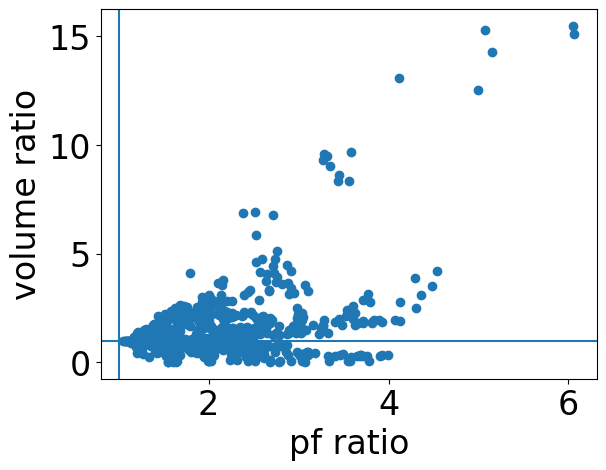

In [69]:
plt.plot(pd_params_stats_pf_infl_ratio_max_min.pf_opt, pd_params_stats_pf_infl_ratio_max_min.volume, 'o')
plt.axhline(1)
plt.axvline(1)
plt.xlabel('pf ratio')
plt.ylabel('volume ratio')

#### Create a similar Fig. 6 but with the common running glaciers of only calib option C5:

- at the moment pseudo_daily and neg_exp are missing, but if I plot that I might rather repeat it instead for an entire RGI region ??? 
    - i.e. : just calib_only_geod_temp_b_0_pf_fit_via_winter_mb for one RGI region, e.g. European Alps  or whatever ... 
- or, if actually ready, use the new better calibration option of OGGM and run it with that (i.e. also a different temp. bias ...)

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/local/sw/python/3.10.5/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils 

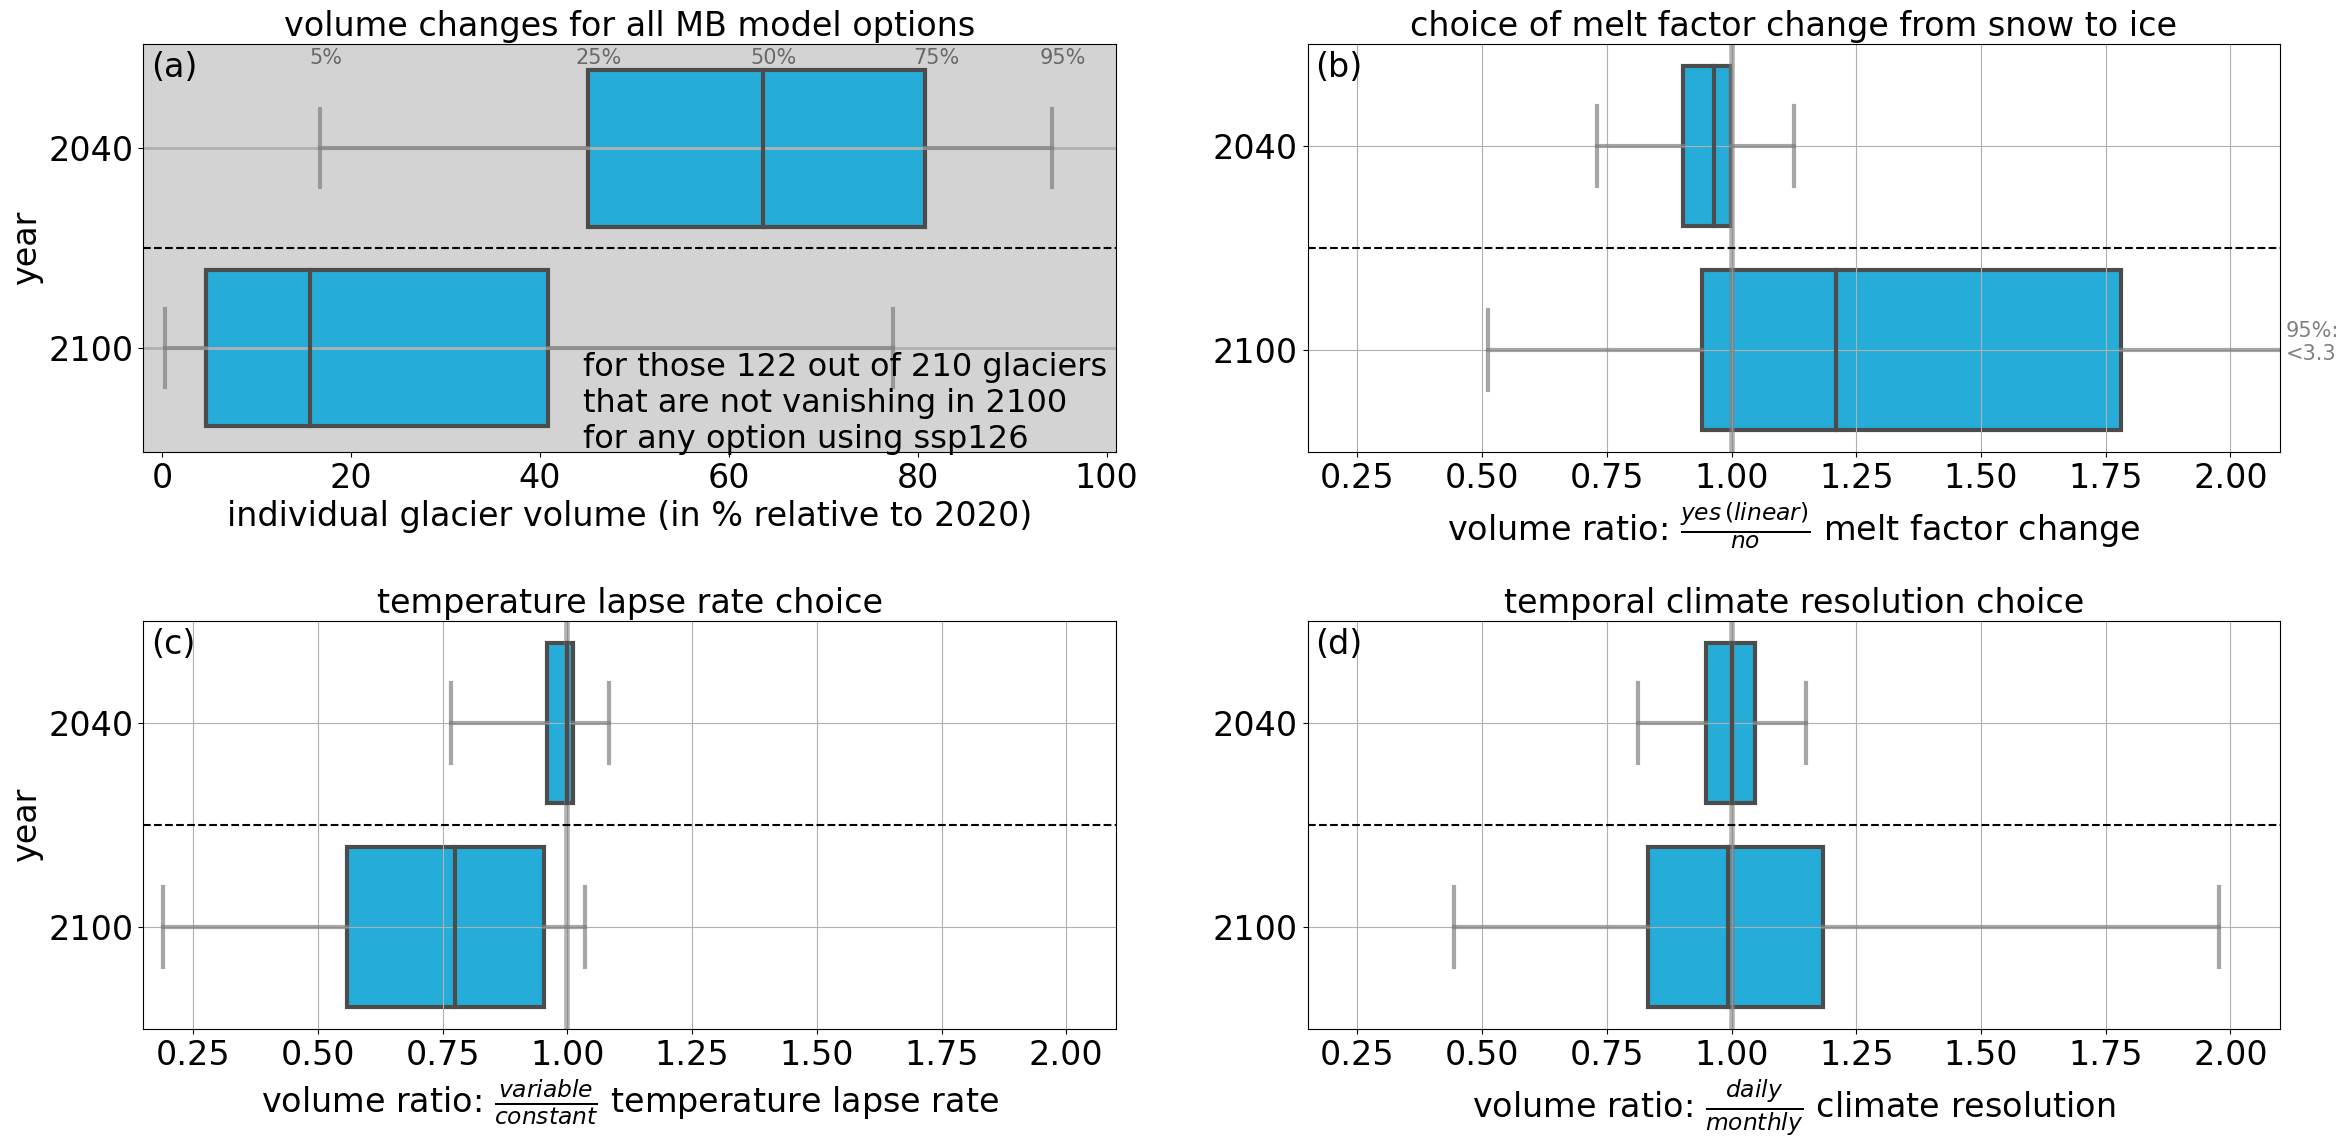

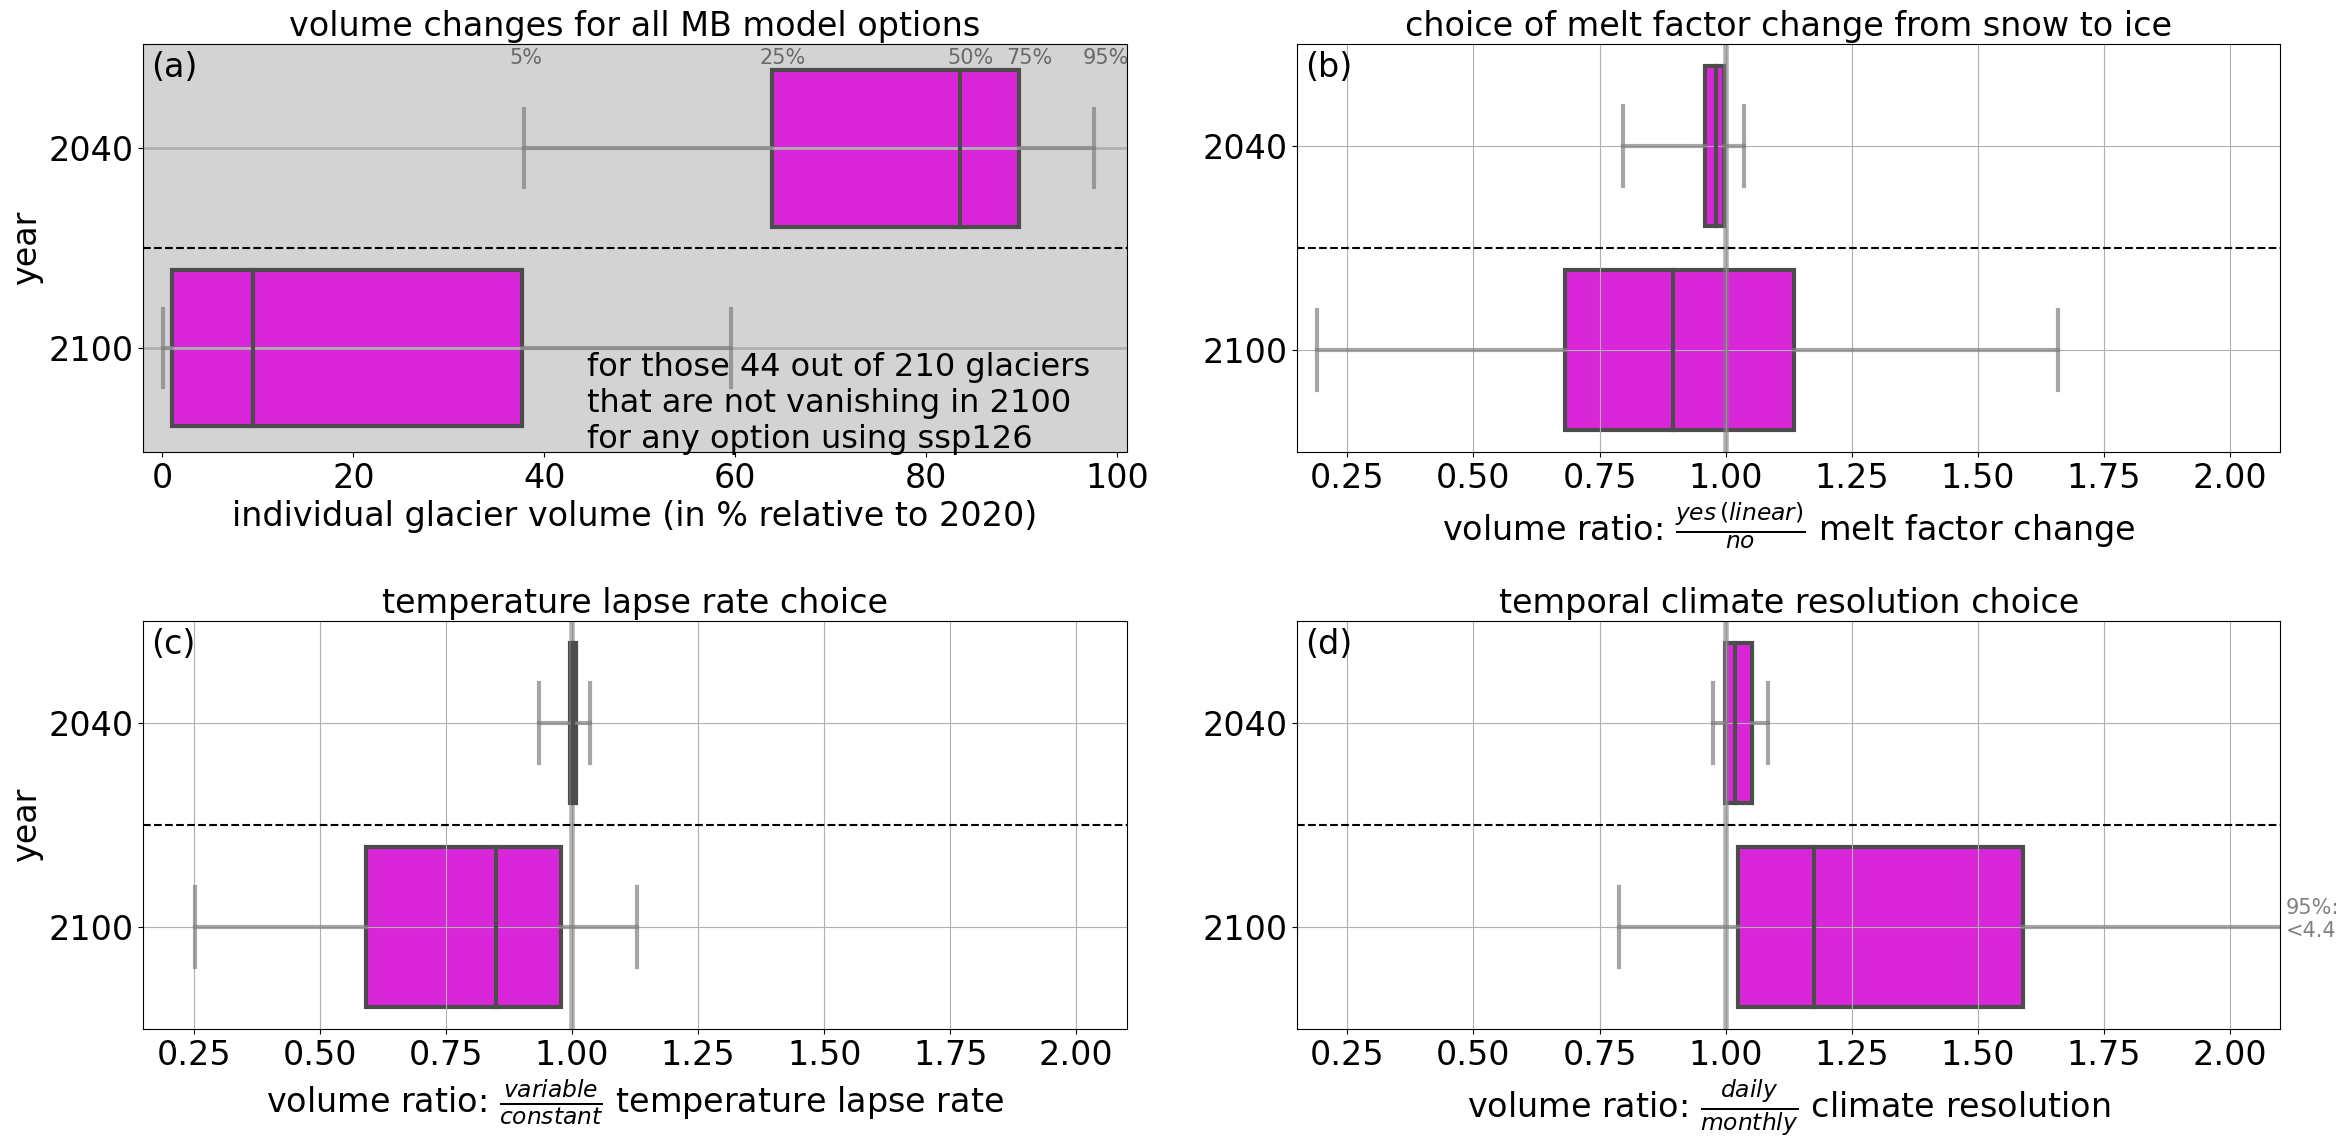

In [53]:
calib_types = ['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
                   'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']
#ds_merged_gcms = xr.open_dataset('hef_test_new_gcm_and_method.nc')
#Schreibtisch/PhD/Schuster_et_al_phd_paper_1/analysis_notebooks/all_refs_W5E5_all_gcms.nc

ds_merged_all_gcms = xr.open_dataset('../trials_or_old_notebooks/poster_all_refs_W5E5_all_gcms.nc')
# instead just take the MEDIAN!!!
ensemble = 'median_gcm'
ds_merged = ds_merged_all_gcms.median(dim='gcm')
ds_merged = ds_merged.sel(calib_type = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb')


ds_merged_2020 = ds_merged.sel(time=2020)
df_merged_vol_yr = ds_merged.sel(time=slice(2000,2100)).to_dataframe().reset_index()
df_merged_vol_yr['mb_grad_type'] = df_merged_vol_yr['mb_type'] + '_' + df_merged_vol_yr['grad_type']
df_merged_vol_yr['sfc_type'] = df_merged_vol_yr['melt_f_change']
df_merged_vol_yr.loc[df_merged_vol_yr.melt_f_change!='False', 'sfc_type'] +='\nmonthly'

df_vol_sum_yr = df_merged_vol_yr.groupby(['calib_type', 'mb_grad_type', 'sfc_type', 'ssp', 'time']).sum().copy().reset_index()
df_merged_vol_yr['relative individual glacier volume compared to 2020 (%)'] = (100*ds_merged.sel(time=slice(2000,2100))/ds_merged_2020).to_dataframe().reset_index().volume

ds_m = ds_merged.sel(time=slice(2040,2100,60)).copy() #.to_dataframe().reset_index() 
len_rgis_run = len(ds_m.rgi_id)
pd_len_rgis = pd.DataFrame(columns=['ssp', 'time', 'still_exist', 'all'])
j = 0
working_dict = {}
for time in [2040, 2100]:
    for ssp in ['ssp126', 'ssp585']:
        # any: it is sufficient that there is for one MB model type or calib type a 0 value -> then it is dropped
        working_dict[f'{time}_{ssp}'] = ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=str(time)).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id.values
        len_rgis_run_t = len(ds_m.sel(ssp=ssp).sel(time=time).where(ds_m.sel(ssp=ssp).sel(time=str(time)).volume>0.001).dropna(dim='rgi_id', how='any').rgi_id)
        pd_len_rgis.loc[j] = np.array([ssp, time, len_rgis_run_t, len_rgis_run])
        j += 1
pd_len_rgis['still_exist'] = pd_len_rgis['still_exist'].astype(int)

# 
plt.rc('font', size=24)

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)'}

violin = False
all_same_glaciers = True ## True
for all_same_glaciers in [True]: ## False
    for ssp in ['ssp126', 'ssp585']:

        if not all_same_glaciers and ssp =='ssp126':
            ssp = np.NaN
        elif not all_same_glaciers and ssp == 'ssp126':
            break

        if all_same_glaciers:
            pd_all = (100*(ds_merged.sel(time=slice(2040,2100,60))/ds_merged.sel(time=2020))).sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            ds_m = ds_merged.sel(time=slice(2040,2100,60)).copy().sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
            if ssp == 'ssp126':
                col_pal_ssp = sns.color_palette(['deepskyblue'])
            else:
                col_pal_ssp = sns.color_palette(['magenta'])

        else:
            pd_all = (100*(ds_merged.sel(time=slice(2040,2100,60))/ds_merged.sel(time=2020))).to_dataframe().reset_index() #.groupby(['ssp', 'calib_type', 'time']).quantile([0.25,0.5,0.75]).round(2)).reset_index()
            col_pal_ssp = sns.color_palette(['deepskyblue', 'red'])


        pd_all['time'] = pd_all.time.astype(int).astype(str)
        if all_same_glaciers:
            fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24,12))
        else:
            fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24,14))

        for option in ['grad_type', 'mb_type','melt_f_change']:
            if option == 'melt_f_change':
                tips = ['linear']
                default = 'False'
            elif option == 'grad_type':
                tips = ['var_an_cycle']
                default = 'cte'
            elif option == 'mb_type':
                tips = ['mb_real_daily']
                default = 'mb_monthly'
            for j, tip in enumerate(tips):

                if option == 'melt_f_change':
                    t = 'choice of melt factor change from snow to ice'
                    ax = axs[j][1]
                    ref_v_opt = ds_merged.sel(time=slice(2040,2100,60)).volume.sel(melt_f_change = default)
                    #ax.set_xlim([0.3,1.65])

                elif option == 'grad_type':
                    t = 'temperature lapse rate choice'
                    ax = axs[1][0]
                    ref_v_opt = ds_merged.sel(time=slice(2040,2100,60)).volume.sel(grad_type = default)
                    #ax.set_xlim([0.25,1.1])
                elif option == 'mb_type':
                    t =  'temporal climate resolution choice'
                    ax = axs[1][1]
                    ref_v_opt = ds_merged.sel(time=slice(2040,2100,60)).volume.sel(mb_type = default)
                    #ax.set_xlim([0.75,1.45])

                if all_same_glaciers:
                    ref_v_opt = ref_v_opt.sel(rgi_id = working_dict[f'2100_{ssp}']).sel(ssp=ssp)
                ds_m_vs_ref = ds_m.volume/ref_v_opt 
                ds_m_vs_ref = ds_m_vs_ref.where(ds_m_vs_ref < np.inf, drop=True) 

                ds = ds_m_vs_ref.to_dataframe().reset_index()
                ds['time'] = ds.time.astype(str)
                ds = ds.loc[ds.volume.dropna().index]
                ds = ds.loc[ds[option] == tip]
                #ds = ds.sort_values(by=['ssp']) #, 'calib_type'])
                if violin:
                    sns.violinplot(x='volume', hue='ssp',data=ds,
                                    fliersize=0, whis=0, y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7, cut = True, ax = ax)
                else:
                    f = sns.boxplot(x='volume', hue='ssp',data=ds,
                                    fliersize=0, whis = [5,95], y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    palette=col_pal_ssp,
                                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},
                                    #legend_out=False
                                    ax = ax) #, legend=False) #, grid=True)
                ax.axvline(1.0, color='grey', linewidth=4, alpha=0.6)
                ax.set_yticklabels(['2040', '2100'])
                if option == 'grad_type':
                    ax.set_ylabel('year')
                else:
                    ax.set_ylabel('')
                handles, labels = ax.get_legend_handles_labels()
                xlim1 = 2.1
                ax.legend_.remove()
                #ax.get_legend()
                if option == 'melt_f_change' and tip == 'linear':
                    ax.set_xlabel(r'volume ratio: $\frac{yes\,(linear)}{no}$ melt factor change', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100.0')].round(1)
                    if q95 > xlim1:
                        ax.text(xlim1+0.01,1.05,r'95%:'+f'\n<{q95}', color = 'grey', fontsize=15)


                elif option == 'melt_f_change' and tip == 'neg_exp':
                    ax.set_xlabel(r'volume ratio: $\frac{neg\_exp}{False}$', fontsize=24)
                elif option == 'grad_type':
                    ax.set_xlabel(r'volume ratio: $\frac{variable}{constant}$ temperature lapse rate', fontsize=24)
                elif option == 'mb_type' and tip == 'mb_pseudo_daily':
                    ax.set_xlabel(r'volume ratio: $\frac{pseudo\_daily}{monthly}$', fontsize=24)
                elif option == 'mb_type' and tip == 'mb_real_daily':
                    ax.set_xlabel(r'volume ratio: $\frac{daily}{monthly}$ climate resolution', fontsize=24)
                    q95 = ds.groupby(['ssp', 'time']).volume.quantile(0.95).loc[(ssp, '2100.0')].round(1)
                    if q95 > xlim1:
                        ax.text(xlim1+0.01,1.05,r'95%:'+f'\n<{q95}', color = 'grey', fontsize=15)


                if j == 0:
                    ax.set_title(t, fontsize=24) 
                ax.grid() #axis='y')
                ax.axhline(0.5,color='black', ls = '--')
                if all_same_glaciers:
                    ax.set_xlim([0.15,xlim1]) # 0.01
                else:
                    ax.set_xlim([0.15,1.65])

        ax = axs[0][0]
        ax.set_facecolor('lightgray')
        sns.boxplot(data=pd_all,
                    x='volume', hue='ssp',
                    fliersize=0, whis = [5,95], y = 'time', #hue_order = ['2040', '2100'],
                    linewidth=3,
                    palette=col_pal_ssp,
                    saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7},
                    #legend_out=False
                    ax = ax)
        qs = pd_all.groupby(['ssp', 'time']).volume.quantile([0.05,0.25,0.5,0.75,0.95]).loc[(ssp, '2040')].values
        #ax.text(qs[0]-14,-0.42,f'percentiles:', color = 'dimgrey', fontsize=15)

        for p,q in enumerate(qs):
            perci = [5,25,50,75,95][p]
            if perci == 5:
                ax.text(q-1.1,-0.42,f'{perci}%', color = 'dimgrey', fontsize=15)
            else:
                ax.text(q-1.3,-0.42,f'{perci}%', color = 'dimgrey', fontsize=15)


        ax.set_xlabel('individual glacier volume (in % relative to 2020)', fontsize=24)
        ax.set_ylabel('year')
        ax.grid(axis='y', lw=2)
        ax.axhline(0.5,color='black', ls = '--')
        ax.set_xlim([-2,101])
        ax.set_ylim([1.52,-0.52])


        p = 0
        ax.set_title('volume changes for all MB model options', fontsize=24)

        if not all_same_glaciers:
            pass
            #ax.text(61, -0.28, f'still existing glaciers:\n(from {len_rgis_run} in total)', fontsize=16)
            #for time in [2040, 2100]:
            #    if time == 2100:
            #        p += 0.3
            ##    for ssp in ['ssp126', 'ssp585']:
            #        n = pd_len_rgis.loc[(pd_len_rgis.ssp ==ssp) & (pd_len_rgis.time ==str(time))]['still_exist'].values[0]
            #        ax.text(72, -0.15+p, f'n={n}')
            #        p += 0.35
            ax.legend(bbox_to_anchor=(0.4,0.2))

        else:
            len_rgis=len(working_dict[f'2100_{ssp}'])
            total = pd_len_rgis['all'][0]
            ax.text(44.5, 1.5,f'for those {len_rgis} out of {total} glaciers\nthat are not vanishing in 2100 \nfor any option using ssp126', fontsize=23)
            #ax.legend(loc='lower right')
            ax.legend_.remove()

        num_dict[5] = '(f)'
        jj= 0
        for axi in axs:
            for ax in axi:
                if not all_same_glaciers:
                    ax.text(0.015,0.95, num_dict[jj], fontsize=22, transform=ax.transAxes) 
                else:
                    ax.text(0.008,0.92, num_dict[jj], fontsize=24, transform=ax.transAxes)    
                jj +=1


        plt.tight_layout()